# Example Notebook For Associating Experimental Signals With The Carbon Network
Prior to running this notebook, the CarbonNetwork graphml file must be present in the build folder

In [16]:
### Preprocessing requirements
import pandas as pd
# 1. Copy all .h5 and .mzML files from the job folders to a single output directory for easier access.
# 2. Run the deconvolution to make <filename>_deconvoluted.parquet files.
import os
import numpy as np
from scipy.stats import ttest_ind
# import ztest
from statsmodels.stats.weightstats import ztest
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

PYTHONPATH = "/global/homes/b/bpb/repos/envnet"
if PYTHONPATH not in sys.path:
    sys.path.insert(0, PYTHONPATH)

from envnet.annotation.core import AnnotationEngine
annotation_engine = AnnotationEngine()
ref_dir = '/global/homes/b/bpb/repos/envnet/results/full_build_20250908_181404/'
node_data = annotation_engine.load_envnet_reference(
    graphml_file=os.path.join(ref_dir, "network_with_sirius.graphml"),
    mgf_base_name=os.path.join(ref_dir, "envnet")
)   
cols = [ 'dbe', 'dbe_ai',
       'dbe_ai_mod', 'ai_mod', 'ai', 'nosc', 'h_to_c', 'o_to_c', 'n_to_c',
       'p_to_c', 'c', 'h', 'o', 'n', 's', 'p', 'original_index','precursor_mz','inchi_key', 'compound_name', 'smiles','NPC#pathway', 'NPC#superclass', 'NPC#class','predicted_formula']
node_data = node_data['nodes'][cols]

cols = ['original_index','predicted_unchanged_in_soil_prob', 'predicted_unchanged_in_soil']
model_data = pd.read_csv('../envnet/data/node_data_with_predicted_unchanged_20251107.csv', usecols=cols)
node_data = node_data.merge(model_data, on='original_index', how='left')

Loading ENVnet reference data...
  GraphML file: /global/homes/b/bpb/repos/envnet/results/full_build_20250908_181404/network_with_sirius.graphml
  Deconvoluted MGF: /global/u2/b/bpb/repos/envnet/data//global/homes/b/bpb/repos/envnet/results/full_build_20250908_181404/envnet_deconvoluted_spectra.mgf
  Original MGF: /global/u2/b/bpb/repos/envnet/data//global/homes/b/bpb/repos/envnet/results/full_build_20250908_181404/envnet_original_spectra.mgf
Loaded 22128 ENVnet nodes


In [14]:
import networkx as nx
G = nx.read_graphml(os.path.join(ref_dir, "network_with_sirius.graphml"))

## Parameters
The next code block sets parameters that are used throughout the remainder of the notebook.

In [ ]:

# mz_ppm_tolerance = 5
# peak_height_min = 1e4
# num_datapoints_min = 10
# # minimum MSMS score 
# msms_score_min = 0.5


# # minimum MSMS matching ion count
# msms_matches_min = 3

# # retention time range in minutes for feature finding
# rt_range = [1, 700]

# # tolerance in daltons used for calculating MS/MS similarity scores
# frag_mz_tolerance = 0.05

In [ ]:
# from importlib import reload
# at = reload(at)

In [4]:
usecols = [ 'permanent_index','label', 'adduct', 'polarity', 'mz',
       'rt_peak', 'file_name',  'experiment', 'inchi', 'name']
df = pd.read_csv('https://github.com/biorack/metatlas-data/blob/main/C18/production/C18_EMA-standards_negative.tsv?raw=true', sep='\t', usecols=usecols)
from rdkit.Chem import InchiToInchiKey
df['inchikey'] = df.inchi.apply(InchiToInchiKey)
df

,permanent_index,label,adduct,polarity,mz,rt_peak,file_name,experiment,inchi,name,inchikey
0,79741,AMINOCAPROIC ACID HYDROCHLORIDE,[M-H]-,negative,130.087353,0.529585,/global/cfs/cdirs/metatlas/raw_data/jgi/202504...,NaN,"InChI=1S/C6H13NO2/c7-5-3-1-2-4-6(8)9/h1-5,7H2,...",AMINOCAPROIC ACID HYDROCHLORIDE,SLXKOJJOQWFEFD-UHFFFAOYSA-N
1,79742,ALENDRONATE SODIUM TRIHYDRATE,[M-H]-,negative,248.009449,0.529932,/global/cfs/cdirs/metatlas/raw_data/jgi/202504...,NaN,"InChI=1S/C4H13NO7P2/c5-3-1-2-4(6,13(7,8)9)14(1...",ALENDRONATE SODIUM TRIHYDRATE,OGSPWJRAVKPPFI-UHFFFAOYSA-N
2,27804,glyceraldehyde,[M-H]-,negative,89.024394,0.539409,20190108_KBL_TN_EMA_MSMLS_Plt12346_QE-HF_C18_U...,20190108_KBL_TN_EMA_MSMLS_Pt5n7_QE-HF_C18_USDA...,"InChI=1S/C3H6O3/c4-1-3(6)2-5/h1,3,5-6H,2H2",glyceraldehyde,MNQZXJOMYWMBOU-UHFFFAOYSA-N
3,34952,lactic acid,[M-H]-,negative,89.024394,0.539459,20190108_KBL_TN_EMA_MSMLS_Plt12346_QE-HF_C18_U...,20190108_KBL_TN_EMA_MSMLS_Pt5n7_QE-HF_C18_USDA...,"InChI=1S/C3H6O3/c1-2(4)3(5)6/h2,4H,1H3,(H,5,6)...",L-Lactic acid,JVTAAEKCZFNVCJ-REOHCLBHSA-N
4,28627,dtdp-alpha-glucose,[M-H]-,negative,563.068456,0.548620,20190108_KBL_TN_EMA_MSMLS_Plt12346_QE-HF_C18_U...,20190108_KBL_TN_EMA_MSMLS_Pt5n7_QE-HF_C18_USDA...,InChI=1S/C16H26N2O16P2/c1-6-3-18(16(25)17-14(6...,dTDP-alpha-D-glucose,YSYKRGRSMLTJNL-URARBOGNSA-N
...,...,...,...,...,...,...,...,...,...,...,...
2923,34454,nervonic acid,[M-H]-,negative,365.342481,8.924247,20190108_KBL_TN_EMA_MSMLS_Plt5n7_QE-HF_C18_USD...,20190108_KBL_TN_EMA_MSMLS_Pt5n7_QE-HF_C18_USDA...,InChI=1S/C24H46O2/c1-2-3-4-5-6-7-8-9-10-11-12-...,Nervonic acid,GWHCXVQVJPWHRF-KTKRTIGZSA-N
2924,73408,8-((1e)-4-cyclohex-1-enyl-2-azabut-1-enyl)-2-[...,[M-H]-,negative,731.406538,8.945223,20190315_KBL-AK_TN_EMA_TimTec-NPL3000_PL1to38_...,20190312_KBL_TN_EMA_TimTecNDL3000_Plates1to38_...,InChI=1S/C46H56N2O6/c1-25(2)35-31-21-27(5)37(4...,8-((1E)-4-cyclohex-1-enyl-2-azabut-1-enyl)-2-[...,WHTFMDSWOMRPEZ-AXITZHBMSA-N
2925,19638,valinomycin,[M+Cl]-,negative,1145.600560,8.998985,20190115_KBL_TN_EMA_Enzo_Pl1to6_QE-HF_C18_USDA...,20190115_KBL_TN_Enzo_Pl1to6_QE-HF_C18_USDAY46918,InChI=1S/C54H90N6O18/c1-22(2)34-49(67)73-31(19...,valinomycin,FCFNRCROJUBPLU-DNDCDFAISA-N
2926,36658,1-({[2-(2-furylmethyl)cyclohexyl]amino}methyle...,[M-H]-,negative,839.427667,9.048340,20190315_KBL-AK_TN_EMA_TimTec-NPL3000_PL1to38_...,20190312_KBL_TN_EMA_TimTecNDL3000_Plates1to38_...,InChI=1S/C52H60N2O8/c1-27(2)41-35-21-29(5)43(4...,1-({[2-(2-furylmethyl)cyclohexyl]amino}methyle...,VNTAPYBNVBWZQH-MEDPLMNLSA-N


In [5]:
data_path = '../results/full_build_20250908_181404/permafrost results gnps2'
ms1_filename = os.path.join(data_path,'ms1_results','ms1_annotations.parquet')
ms2_filename = os.path.join(data_path,'ms2_results','ms2_deconvoluted_annotations.parquet')
analysis_filename = os.path.join(data_path,'analysis_results','statistical_results.csv')

In [6]:

cols = """inchi_key_identity
name_identity
ms2_score
ms2_matches
mz_centroid
rt_peak
p_value
t_score
log2_foldchange"""
cols = cols.split('\n')
output = pd.read_csv(analysis_filename)#,usecols=cols)
output = pd.merge(output,node_data,on='original_index',how='left')
output = output[output['inchi_key'].isin(df.inchikey)]
output = output[output['p_value'] < 0.05]
# output = output[output['ms2_matches'] > msms_matches_min]
# output = pd.merge(output, df, left_on='inchi_key_identity', right_on='inchikey', how='inner')
output.sort_values('log2_foldchange', ascending=False, inplace=True)
output.to_csv('output.csv', index=False)
output

,original_index,mean-20M,mean-55M,median-20M,median-55M,standard_error-20M,standard_error-55M,std_dev-20M,std_dev-55M,p_value,...,precursor_mz,inchi_key,compound_name,smiles,NPC#pathway,NPC#superclass,NPC#class,predicted_formula,predicted_unchanged_in_soil_prob,predicted_unchanged_in_soil
4252,1973926,3.266529e+07,3.950576e+08,3.187392e+07,3.951254e+08,1.471346e+06,3.897539e+06,2.548447e+06,6.750736e+06,1.046973e-07,...,325.09292,MOLPUWBMSBJXER-YDGSQGCISA-N,Bilobalide,CC(C)(C)[C@]1(O)C[C@@H]2OC(=O)C[C@@]23C(=O)O[C...,Terpenoids,Sesquiterpenoids,Picrotoxane sesquiterpenoids,C15H18O8,0.000269,0
11326,3746973,1.260000e+07,1.375173e+08,1.217055e+07,1.376403e+08,6.086698e+05,7.827793e+05,1.054247e+06,1.355814e+06,2.381126e-08,...,407.134972,FPUXKXIZEIDQKW-JHYXGPMBSA-N,CCG-208577,C[C@@H]1C(=O)O[C@H]2C[C@@]34C5C[C@@H](C(C)(C)C...,Terpenoids,Diterpenoids,Gibberellins,C20H24O9,0.008129,0
7181,2757586,6.292839e+06,2.360851e+07,6.343054e+06,2.207543e+07,2.686025e+05,1.580356e+06,4.652332e+05,2.737256e+06,4.166146e-04,...,359.186213,MFYSYFVPBJMHGN-ZPOLXVRWSA-N,Andreson,C[C@]12CC(=O)[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43...,Terpenoids,Diterpenoids,Pregnane steroids,C21H28O5,0.989178,1
2841,1625202,9.669142e+07,3.528977e+08,9.329010e+07,3.529828e+08,8.053096e+06,2.002164e+06,1.394837e+07,3.467849e+06,6.557043e-06,...,309.097939,RYEFFICCPKWYML-QCGISDTRSA-N,picrotin,CC(C)(O)[C@H]1[C@@H]2C(=O)O[C@H]1[C@H]1OC(=O)[...,Terpenoids,Sesquiterpenoids,Picrotoxane sesquiterpenoids,C15H18O7,0.003519,0
3802,1836373,3.652632e+07,1.065075e+08,3.672095e+07,1.061124e+08,1.549031e+06,1.440072e+06,2.683000e+06,2.494277e+06,4.975561e-06,...,319.11877,HPNSFSBZBAHARI-RUDMXATFSA-N,mycophenolic acid,COc1c(C)c2c(c(O)c1C/C=C(\C)CCC(=O)O)C(=O)OC2,Polyketides,Cyclic polyketides,Phthalide derivatives,C17H20O6,0.994510,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1098,1254230,2.724887e+08,6.222398e+06,2.709938e+08,6.631487e+06,1.634082e+07,4.605574e+05,2.830313e+07,7.977088e+05,8.314497e-05,...,283.097135,SWUARLUWKZWEBQ-VQHVLOKHSA-N,Caffeic acid phenethyl ester,O=C(/C=C/c1ccc(O)c(O)c1)OCCc1ccccc1,Polyketides,Aromatic polyketides,Depsides and depsidones,C17H16O4,0.006339,0
15907,44707,2.003352e+07,2.530225e+05,1.600832e+07,2.378880e+05,5.308981e+06,2.756045e+04,9.195425e+06,4.773610e+04,2.037117e-02,...,134.046648,GFFGJBXGBJISGV-UHFFFAOYSA-N,adenine,Nc1nc[nH]c2ncnc1-2,Alkaloids,Pseudoalkaloids (transamidation),Purine alkaloids,C5H5N5,0.035419,0
3146,172704,1.345435e+10,6.174439e+07,1.334281e+10,6.148295e+07,1.809782e+08,5.040290e+05,3.134634e+08,8.730039e+05,1.998359e-07,...,165.055928,VOXXWSYKYCBWHO-UHFFFAOYSA-N,DL-3-Phenyllactic acid,O=C(O)C(O)Cc1ccccc1,Shikimates and Phenylpropanoids,Phenylpropanoids (C6-C3),Cinnamic acids and derivatives,C9H10O3,0.004786,0
2314,1534154,3.206669e+05,0.000000e+00,3.001694e+05,0.000000e+00,3.110038e+04,0.000000e+00,5.386744e+04,0.000000e+00,4.991632e-04,...,300.998409,AFSDNFLWKVMVRB-UHFFFAOYSA-N,ellagic acid,O=c1oc2c(O)c(O)cc3c(=O)oc4c(O)c(O)cc1c4c23,Shikimates and Phenylpropanoids,Phenolic acids (C6-C1),Gallotannins,C6H10N2O10S,0.336040,0


In [ ]:
# cols = """inchi_key_identity
# name_identity
# ms2_score
# ms2_matches
# mz_centroid
# rt_peak
# peak_area
# peak_height
# p_value
# t_score
# log2_foldchange
# mean-20M
# std_dev-20M
# mean-55M
# std_dev-55M"""
# cols = cols.split('\n')
# output = pd.read_csv('Permafrost_-_20M_vs._55M_Norm-7be99f94122347c388b9cee5d8008436-output_group1-vs-group2.csv',usecols=cols)
# sum((output['ms2_matches']>2) & (output['ms2_score']>0.7)), sum(output['peak_area']>1e6)

(2480, 10359)

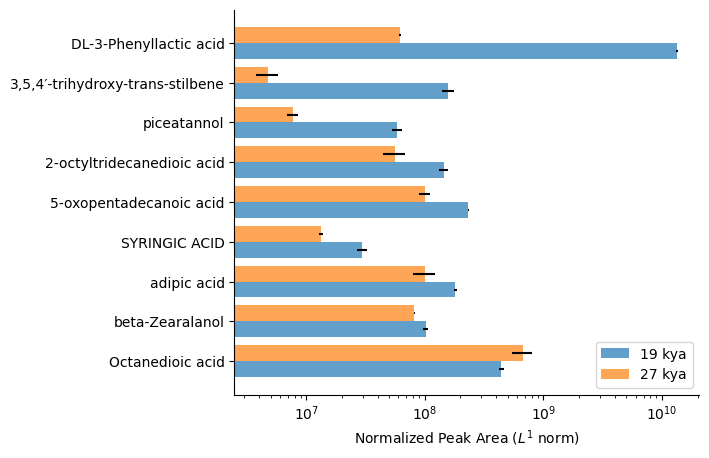

In [7]:
# running a targeted analysis, yielded this list of inchikeys
passing_inchikeys = """WNLRTRBMVRJNCN-UHFFFAOYSA-N
JMSVCTWVEWCHDZ-UHFFFAOYSA-N
FJKROLUGYXJWQN-UHFFFAOYSA-N
VOXXWSYKYCBWHO-UHFFFAOYSA-N
RHMXXJGYXNZAPX-UHFFFAOYSA-N
KXGVEGMKQFWNSR-LLQZFEROSA-N
LUKBXSAWLPMMSZ-OWOJBTEDSA-N
KGDFFRUWAGMXRB-UHFFFAOYSA-N
TYFQFVWCELRYAO-UHFFFAOYSA-N
DWTTZBARDOXEAM-JSGCOSHPSA-N
CDRPUGZCRXZLFL-OWOJBTEDSA-N
RNMOYYIVANEQIG-UHFFFAOYSA-N"""
passing_inchikeys = passing_inchikeys.split('\n')
# cols = """inchi_key_identity
# name_identity
# ms2_score
# ms2_matches
# mz_centroid
# rt_peak
# p_value
# t_score
# log2_foldchange
# mean-20M
# std_dev-20M
# mean-55M
# std_dev-55M"""
# cols = cols.split('\n')
# output = pd.read_csv('Permafrost_-_20M_vs._55M_Norm-7be99f94122347c388b9cee5d8008436-output_group1-vs-group2.csv',usecols=cols)
output = output[output['inchi_key'].isin(passing_inchikeys)]
output = output[output['p_value'] < 0.05]
# output = output[output['ms2_matches'] > msms_matches_min]
# output = pd.merge(output, df, left_on='inchi_key_identity', right_on='inchikey', how='inner')
output.sort_values('log2_foldchange', ascending=False, inplace=True)

# rename the compound with name_identity
new_name = '3,5,4′-trihydroxy-trans-stilbene'
old_name = '501-36-0'
output['compound_name'] = output['compound_name'].replace(old_name, new_name)

output.drop_duplicates('inchi_key', inplace=True)
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,5))
# make an errorbar chart
output['mean-20M'] = output['mean-20M'].astype(float)
output['mean-55M'] = output['mean-55M'].astype(float)
output['std_dev-20M'] = output['std_dev-20M'].astype(float)
output['std_dev-55M'] = output['std_dev-55M'].astype(float)
compound_labels = output['compound_name']
x = np.arange(len(compound_labels))
# make horizontal error bar plot
# Create horizontal bar chart with error bars
# Define bar width and offset
bar_width = 0.4
offset = bar_width / 2

# Create horizontal bar chart with error bars
ax.barh(x - offset, output['mean-20M'], xerr=output['std_dev-20M'], height=bar_width, align='center', alpha=0.7, label='19 kya')
ax.barh(x + offset, output['mean-55M'], xerr=output['std_dev-55M'], height=bar_width, align='center', alpha=0.7, label='27 kya')

ax.set_yticks(x)
ax.set_yticklabels(compound_labels)

ax.set_xlabel(r'Normalized Peak Area ($\mathit{L}^{1}$ norm)')
# ax.set_ylabel('Compound')

# remove top and bottom plot lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xscale('log')
ax.legend()
# ax.grid()
plt.show()

Index(['Unnamed: 0', 'NPC#class', 'mean', 'stderror', 'count',
       'positive_count', 'negative_count', 'binomial_pvalue'],
      dtype='object')


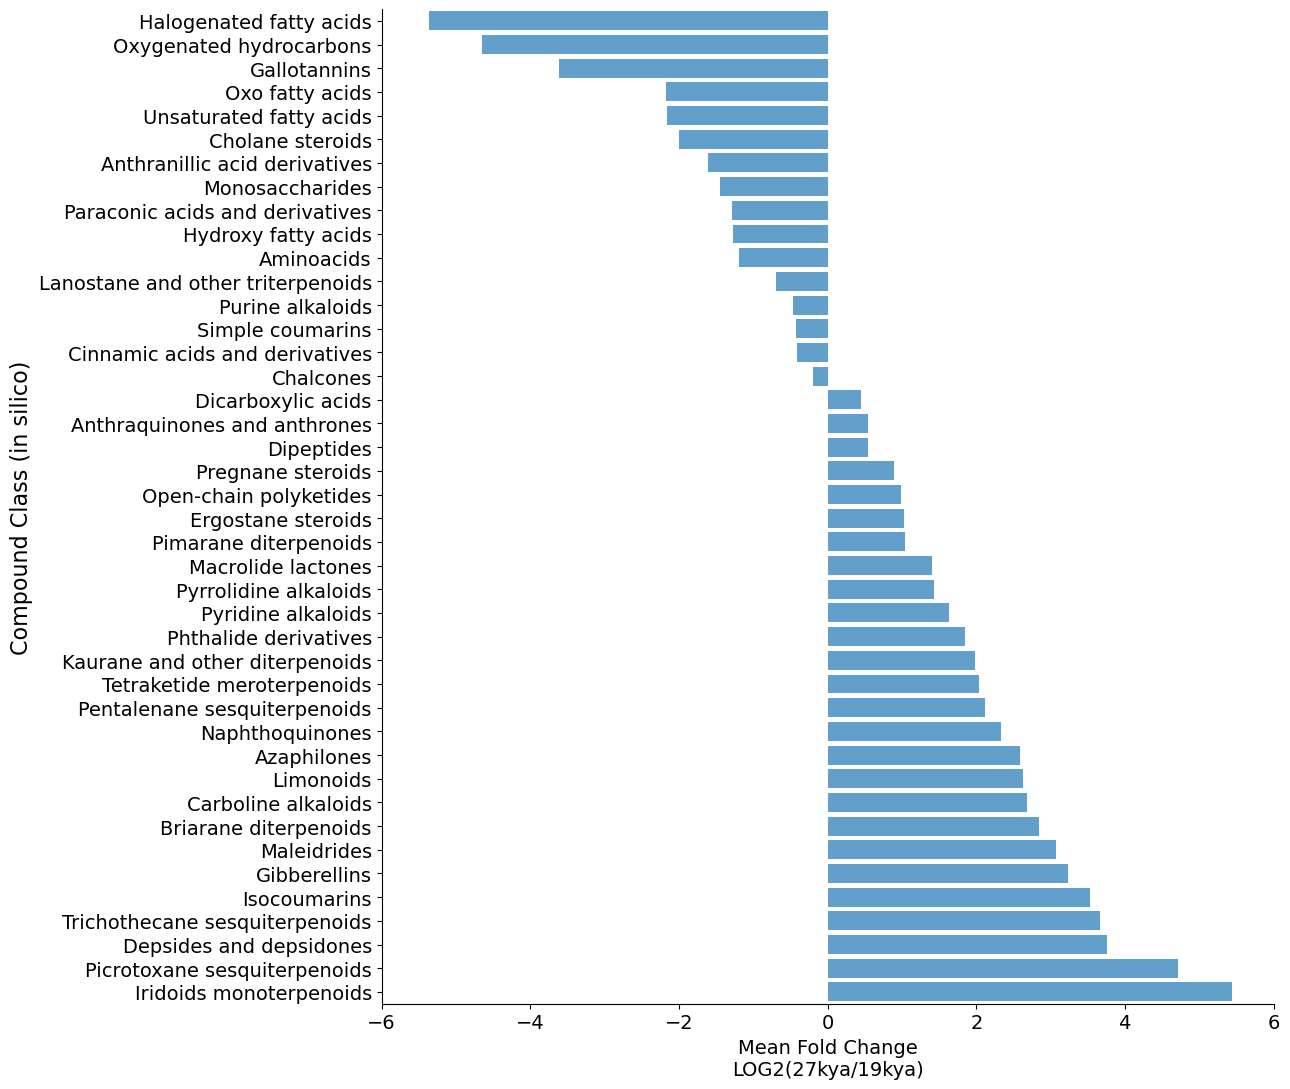

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
class_analysis_filename = '/global/homes/b/bpb/repos/envnet/results/full_build_20250908_181404/permafrost results gnps2/analysis_results/class_output_csv/NPC#class_enrichment.csv'
df = pd.read_csv(class_analysis_filename)
print(df.columns)
# df = df[abs(df['mean'])>1]
df = df[df['count']>50]
fig,ax = plt.subplots(figsize=(13,11))
compound_labels = df['NPC#class']
# shorted compound labels
shorten_dict = {'Lanostane, Tirucallane and Euphane triterpenoids':'Lanostane and other triterpenoids',
                'Kaurane and Phyllocladane diterpenoids':'Kaurane and other diterpenoids',
                'Pimarane and Isopimarane diterpenoids':'Pimarane diterpenoids'}
compound_labels = compound_labels.replace(shorten_dict)
x = np.arange(len(compound_labels))
y = df['mean']
yerr = df['stderror']
ax.barh(x, y,align='center', alpha=0.7, ecolor='black', capsize=10)
ax.set_yticks(x)
ax.set_yticklabels(compound_labels, rotation=0, ha='right')
# ax.set_xlabel('Propagated Class',fontsize=20)
ax.set_xlabel('Mean Fold Change\nLOG2(27kya/19kya)',fontsize=14)
# change font of tick labels
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylabel('Compound Class (in silico)',fontsize=16)
# ax.grid()
ax.set_xlim(-6,6)
ax.set_ylim(x.min()-0.5,x.max()+0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import networkx as nx

# sys.path.insert(0,'/global/homes/b/bpb/repos/envnet/envnet/use')
# import analysis_tools as at

# df = pd.read_csv('../../data/output_group1-vs-group2.csv')
# df['envnet_node_id'] = df['envnet_node_id'].astype(str)
# # G = nx.read_graphml('../../data/envnet.graphml')
# G = nx.read_graphml('../../data/AnnotatedENVnet.graphml')
# # node_data = at.graph_to_df()


In [ ]:

# node_data = node_data.dropna(subset=['smiles_identity'])
# smiles = list(set(node_data['smiles_identity'].tolist()))
# from rdkit.Chem import MolFromSmiles
# mols = [MolFromSmiles(s) for s in smiles]


# from rdkit.Chem import MolFromSmarts
# pat = '[$([C]([#6])([#6])([#6])[#6])]'
# # find the smarts substructure in the molecules
# quat_pat = MolFromSmarts(pat)
# # count the substructure matches in each molecule
# num_quat = np.array([len(mol.GetSubstructMatches(quat_pat)) for mol in mols])
# # count the number of total Carbon atoms in each molecule
# sorted_idx = np.argsort(num_quat)[::-1]
# sorted_idx = sorted_idx[:20]
# top_smiles = [smiles[i] for i in sorted_idx]
# nodes_we_want = node_data.loc[node_data['smiles_identity'].isin(top_smiles),'node_id'].to_list()

# bottom_idx = np.argwhere(num_quat == 0).flatten()
# bottom_smiles = [smiles[i] for i in bottom_idx]
# low_nodes = node_data.loc[node_data['smiles_identity'].isin(bottom_smiles),'node_id'].to_list()


In [14]:
# fig,ax = plt.subplots(
# )
# ax.plot(df['mean-19 kya'],df['mean-27 kya'],'.',label='All',alpha=0.5)

# idx = node_data['high_quaternary_propagated'] == "Neighbors of three or more quaternary Carbons"
# nodes = node_data.loc[idx,'node_id'].tolist()
# ax.plot(df.loc[df['envnet_node_id'].isin(nodes),'mean-19 kya'],df.loc[df['envnet_node_id'].isin(nodes),'mean-27 kya'],'.',label='Neighbors of >3 quat. Carbon')

# idx = node_data['high_quaternary'] == "Three or more quaternary Carbons"
# nodes = node_data.loc[idx,'node_id'].tolist()
# # ['mean-20M', 'mean-55M']
# ax.plot(df.loc[df['envnet_node_id'].isin(nodes),'mean-19 kya'],df.loc[df['envnet_node_id'].isin(nodes),'mean-27 kya'],'k.',label='3 or more quat. Carbon atoms')
# ax.plot([1e4,1e8],[1e4,1e8],'k--')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlabel('19 kya')
# ax.set_ylabel('29 kya')
# # legend with no box
# ax.legend(frameon=False)

# ax.axes.set_aspect('equal')
# ax.set_xlim(1e4,1e10)
# ax.set_ylim(1e4,1e10)

In [15]:
# [c for c in df.columns if 'score' in c]

# Find out which identity node has the most old permafrost nodes neighboring it

In [9]:
import networkx as nx
graphml_filename = '/global/homes/b/bpb/repos/envnet/results/full_build_20250908_181404/permafrost results gnps2/analysis_results/envnet_network_annotated.graphml'
G = nx.read_graphml(graphml_filename)

data_path = '../results/full_build_20250908_181404/permafrost results gnps2'
analysis_filename = os.path.join(data_path,'analysis_results','statistical_results.csv')

output = pd.read_csv(analysis_filename)#,usecols=cols)
output = pd.merge(output,node_data,on='original_index',how='left')

In [24]:
ms2_df = pd.read_parquet(ms2_filename)
nodes_with_ms2 = ms2_df['original_index_deconvoluted_match'].tolist()
idx = (output['log2_foldchange'] > 1) & (output['p_value'] < 0.05)# & (pd.notna(output['inchi_key']))
node_increased_27kya = output.loc[idx,'original_index'].astype(int).tolist()

idx = (output['log2_foldchange'] < -1) & (output['p_value'] < 0.05)
# idx = (idx) & (pd.notna(output['inchi_key']))
node_with_id_increased_19kya = output.loc[idx,'original_index'].astype(int).tolist()

my_nodes = node_increased_27kya + node_with_id_increased_19kya
my_nodes = list(set(my_nodes))
my_nodes = list(set(my_nodes) & set(nodes_with_ms2))

print(f"Number of nodes: {len(my_nodes)}")


# Now filter edges based on original_index values
edges = G.edges()
print(f"Total edges in graph: {len(edges)}")

edges = G.edges()
# remove all edges that do not have a node_with_id increased in 19kya
edges = [(u,v) for u,v in edges if int(u) in my_nodes or int(v) in my_nodes]
print(f"Filtered edges in graph: {len(edges)}")

Number of nodes: 1711
Total edges in graph: 390714
Filtered edges in graph: 141799
Filtered edges in graph: 141799


In [25]:
# cols = ['original_index', 'p_value', 'log2_foldchange',
#         'inchi_key', 'compound_name',
#        'predicted_formula']
# df = pd.merge(pd.DataFrame(edges,columns=['source','target']).astype(int),output[cols].add_suffix('_source'),left_on='source',right_on='original_index_source',how='left')
# df = pd.merge(df,output[cols].add_suffix('_target'),left_on='target',right_on='original_index_target',how='left')


In [10]:
from copy import deepcopy
cols = ['original_index', 'p_value', 'log2_foldchange',
        'inchi_key', 'compound_name',
       'predicted_formula']

df = pd.merge(pd.DataFrame(edges,columns=['source','target']).astype(int),output[cols].add_suffix('_source'),left_on='source',right_on='original_index_source',how='left')
df = pd.merge(df,output[cols].add_suffix('_target'),left_on='target',right_on='original_index_target',how='left')
# df = df[df['predicted_formula_source'].str.contains('C10')]
g = df[pd.notna(df['inchi_key_source'])].groupby('source').agg({'log2_foldchange_source':'median','target':'count'})
g.sort_values('log2_foldchange_source',ascending=True,inplace=True)
g = pd.merge(g,node_data,left_index=True,right_on='original_index')
g = g[g['target']>8]

# Store the original edges to avoid modification issues
original_edges = list(edges)  # Make a copy of the edges list
list_of_graphs = []
for i,row in g.head(100).iterrows():
    print(f"{row['compound_name']}: {row['log2_foldchange_source']:.2f} ({row['target']} connections)")
    # make an ego graph for "original_index" node this needs to be a deep copy so as to not modify the original graph
    partial_G = deepcopy(G)
    ego = nx.ego_graph(partial_G, str(row['original_index']), radius=1)
    print(f"  Ego graph has {ego.number_of_nodes()} nodes and {ego.number_of_edges()} edges")
    
    # Remove edges between neighboring nodes, keep only edges connected to the ego node (hub)
    ego_node = str(row['original_index'])
    edges_to_remove = []
    for u, v in ego.edges():
        # Remove edge if neither node is the ego node (i.e., it's an edge between neighbors)
        if u != ego_node and v != ego_node:
            edges_to_remove.append((u, v))
    
    ego.remove_edges_from(edges_to_remove)
    print(f"  After removing neighbor-to-neighbor edges: {ego.number_of_nodes()} nodes and {ego.number_of_edges()} edges")
    
    basedir = graphml_filename.rsplit('/',1)[0]
    sub_folder = "ego_graphs"
    sub_folder = os.path.join(basedir,sub_folder)
    if not os.path.exists(sub_folder):
        os.makedirs(sub_folder)
    ego_filename = f"ego_graph_node_{row['original_index']}.graphml"
    ego_filename = os.path.join(sub_folder, ego_filename)
    nx.write_graphml(ego, ego_filename)
    print(f"Saved ego graph to {ego_filename}")
    list_of_graphs.append(ego)
# merge the list of graphs into a single graph
merged_graph = nx.compose_all(list_of_graphs)
merged_graph_filename = os.path.join(sub_folder, "merged_ego_graphs.graphml")
nx.write_graphml(merged_graph, merged_graph_filename)
print(f"Saved merged ego graph to {merged_graph_filename}")

NameError: name 'edges' is not defined

In [11]:
temp.columns

Index(['original_index', 'mean-20M', 'mean-55M', 'median-20M', 'median-55M',
       'standard_error-20M', 'standard_error-55M', 'std_dev-20M',
       'std_dev-55M', 'p_value', 't_score', 'log2_foldchange',
       'peak_values_normalized', 'peak_value_used', 'control_group',
       'treatment_group', 'precursor_mz', 'inchi_key', 'compound_name',
       'smiles', 'NPC#pathway', 'NPC#superclass', 'NPC#class',
       'predicted_formula', 'predicted_unchanged_in_soil',
       'predicted_unchanged_in_soil_prob'],
      dtype='object')

In [19]:
output['NPC#superclass'].value_counts()

Diterpenoids                  3493
Sesquiterpenoids              2380
Fatty Acids and Conjugates    2090
Small peptides                1739
Aromatic polyketides           903
                              ... 
Glycerolipids                    2
Polyethers                       2
Alkylresorsinols                 1
Polyols                          1
Diarylheptanoids                 1
Name: NPC#superclass, Length: 64, dtype: int64

In [18]:
output.loc[output['NPC#superclass']=='Meroterpenoids','log2_foldchange'].mean()

1.5918350329005637

In [17]:
output.loc[output['NPC#superclass']=='Meroterpenoids','predicted_unchanged_in_soil'].value_counts()

1    214
0     81
Name: predicted_unchanged_in_soil, dtype: int64

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Common Setup and Data Loading ---
# This part is run only once to load and prepare the data.
data_path = '../results/full_build_20250908_181404/permafrost results gnps2'
analysis_filename = os.path.join(data_path, 'analysis_results', 'statistical_results.csv')

# Load the data
output = pd.read_csv(analysis_filename)

# NOTE: The 'node_data' DataFrame needs to be loaded or defined before this line.
# For example: node_data = pd.read_csv('path/to/your/node_data.csv')
# As a placeholder, let's assume node_data is an empty DataFrame if it doesn't exist
if 'node_data' not in locals():
    print("Warning: 'node_data' not found. Creating an empty DataFrame.")
    # This assumes 'original_index' is the merge key. Adjust if necessary.
    node_data = pd.DataFrame({'original_index': output['original_index'].unique()})


output = pd.merge(output, node_data, on='original_index', how='left')

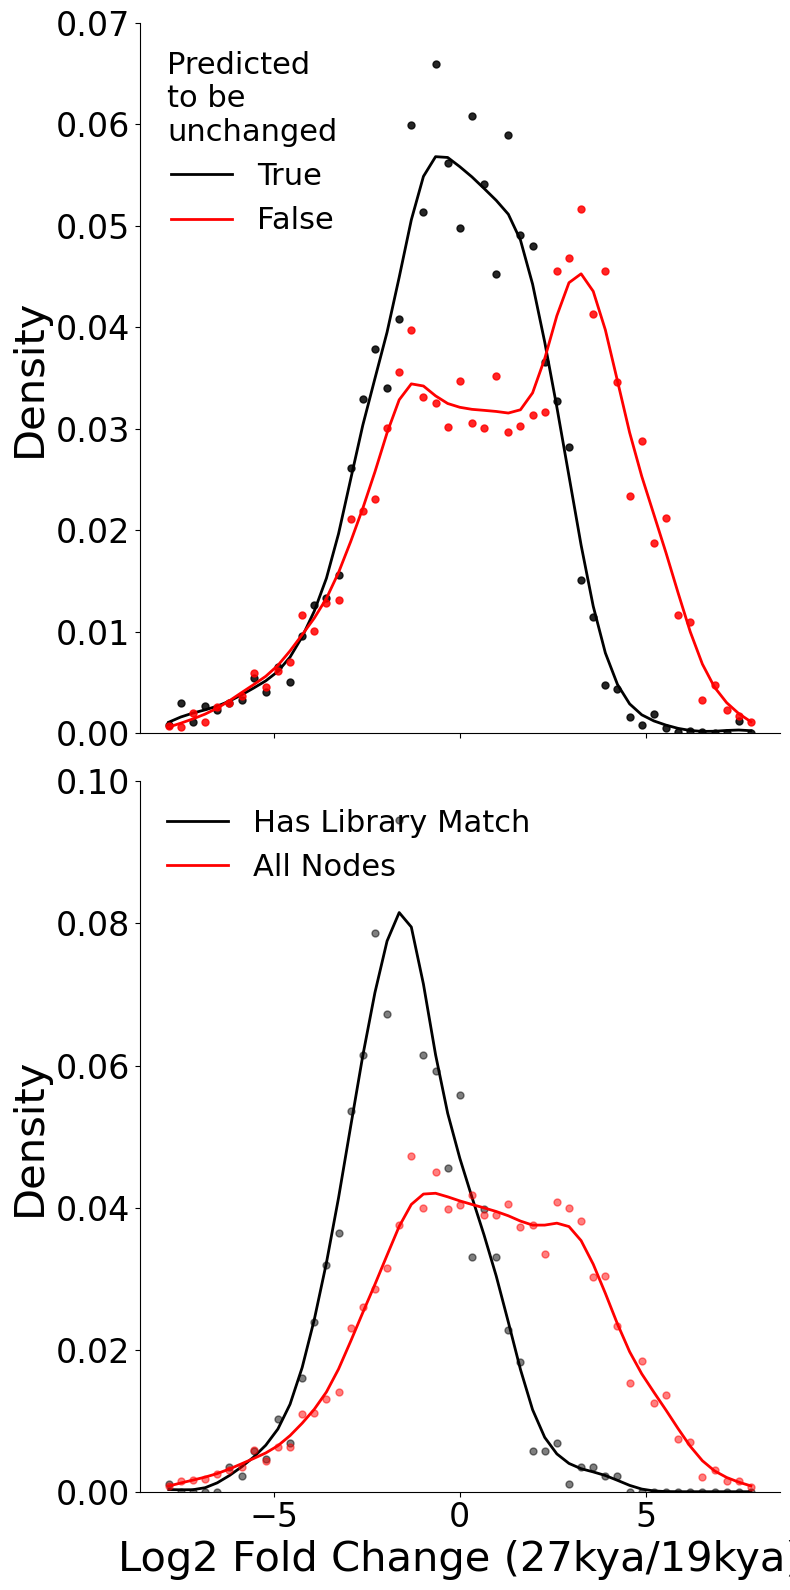

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Common Setup and Data Loading ---
# This part is run only once to load and prepare the data.
data_path = '../results/full_build_20250908_181404/permafrost results gnps2'
analysis_filename = os.path.join(data_path, 'analysis_results', 'statistical_results.csv')

# Load the data
output = pd.read_csv(analysis_filename)

# NOTE: The 'node_data' DataFrame needs to be loaded or defined before this line.
# For example: node_data = pd.read_csv('path/to/your/node_data.csv')
# As a placeholder, let's assume node_data is an empty DataFrame if it doesn't exist
if 'node_data' not in locals():
    print("Warning: 'node_data' not found. Creating an empty DataFrame.")
    # This assumes 'original_index' is the merge key. Adjust if necessary.
    node_data = pd.DataFrame({'original_index': output['original_index'].unique()})


output = pd.merge(output, node_data, on='original_index', how='left')


# --- Create Subplots ---
# Create a figure with 2 rows, 1 column. 
# The figsize height is doubled to maintain the aspect ratio of the original plots.
fig, axes = plt.subplots(2, 1, figsize=(8, 16),sharex=True)


# --- Panel A: Model Prediction ---
ax1 = axes[0]
temp = output.copy()
temp = temp[pd.notna(temp['log2_foldchange'])]
temp = temp[pd.notna(temp['predicted_unchanged_in_soil_prob'])]

idx_identified = (temp['predicted_unchanged_in_soil'] == 1)
edges = np.linspace(-8, 8, 50)

# Plot 'Unchanged' data
y, x = np.histogram(temp.loc[idx_identified, 'log2_foldchange'], bins=edges, density=False)
x = (x[1:] + x[:-1]) / 2
pat = np.exp(-x**2 / (2 * 0.5**2))
smooth_y = np.convolve(y, pat, mode='same')
smooth_y /= np.sum(smooth_y)
# FIX: Change from in-place division to standard assignment
y = y / np.sum(y) 
ax1.plot(x, y, 'k.', alpha=0.85, markersize=10)
ax1.plot(x, smooth_y, 'k-', label='True', alpha=1, linewidth=2)

# Plot 'Changed' data
idx_identified = (temp['predicted_unchanged_in_soil'] == 0)

y, x = np.histogram(temp.loc[idx_identified, 'log2_foldchange'], bins=edges, density=False)
x = (x[1:] + x[:-1]) / 2
smooth_y = np.convolve(y, pat, mode='same')
smooth_y /= np.sum(smooth_y)
# FIX: Change from in-place division to standard assignment
y = y / np.sum(y)
ax1.plot(x, y, 'r.', alpha=0.85, markersize=10)
ax1.plot(x, smooth_y, 'r-', label='False', alpha=1, linewidth=2)

# Panel-specific formatting
ax1.legend(frameon=False, fontsize=22, loc='upper left', title='Predicted\nto be\nunchanged', title_fontsize=22)
ax1.set_ylim(0, 0.07)


# --- Panel B: Library Match ---
ax2 = axes[1]
temp = output.copy()
temp = temp[pd.notna(temp['log2_foldchange'])]

idx_identified = pd.notna(temp['inchi_key'])

# Plot 'Has Library Match' data
y, x = np.histogram(temp.loc[idx_identified, 'log2_foldchange'], bins=edges, density=False)
x = (x[1:] + x[:-1]) / 2
pat = np.exp(-x**2 / (2 * 0.5**2))
smooth_y = np.convolve(y, pat, mode='same')
smooth_y /= np.sum(smooth_y)
# FIX: Change from in-place division to standard assignment
y = y / np.sum(y)
ax2.plot(x, y, 'k.', alpha=0.5, markersize=10)
ax2.plot(x, smooth_y, 'k-', label='Has Library Match', alpha=1, linewidth=2)

# Plot 'All Nodes' data
y, x = np.histogram(temp['log2_foldchange'], bins=edges, density=False)
x = (x[1:] + x[:-1]) / 2
smooth_y = np.convolve(y, pat, mode='same')
smooth_y /= np.sum(smooth_y)
# FIX: Change from in-place division to standard assignment
y = y / np.sum(y)
ax2.plot(x, y, 'r.', alpha=0.5, markersize=10)
ax2.plot(x, smooth_y, 'r-', label='All Nodes', alpha=1, linewidth=2)

# Panel-specific formatting
ax2.legend(frameon=False, fontsize=22, loc='upper left')
ax2.set_ylim(0, 0.1)


# --- Apply Common Formatting to Both Panels ---
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel('Density', fontsize=30)
    ax.xaxis.set_tick_params(labelsize=24)
    ax.yaxis.set_tick_params(labelsize=24)
ax2.set_xlabel('Log2 Fold Change (27kya/19kya)', fontsize=30)

# Use tight_layout to ensure labels and titles do not overlap
plt.tight_layout()
plt.show()

In [4]:
output.columns

Index(['original_index', 'mean-20M', 'mean-55M', 'median-20M', 'median-55M',
       'standard_error-20M', 'standard_error-55M', 'std_dev-20M',
       'std_dev-55M', 'p_value', 't_score', 'log2_foldchange',
       'peak_values_normalized', 'peak_value_used', 'control_group',
       'treatment_group', 'precursor_mz', 'inchi_key', 'compound_name',
       'smiles', 'NPC#pathway', 'NPC#superclass', 'NPC#class',
       'predicted_formula', 'predicted_unchanged_in_soil_prob',
       'predicted_unchanged_in_soil'],
      dtype='object')

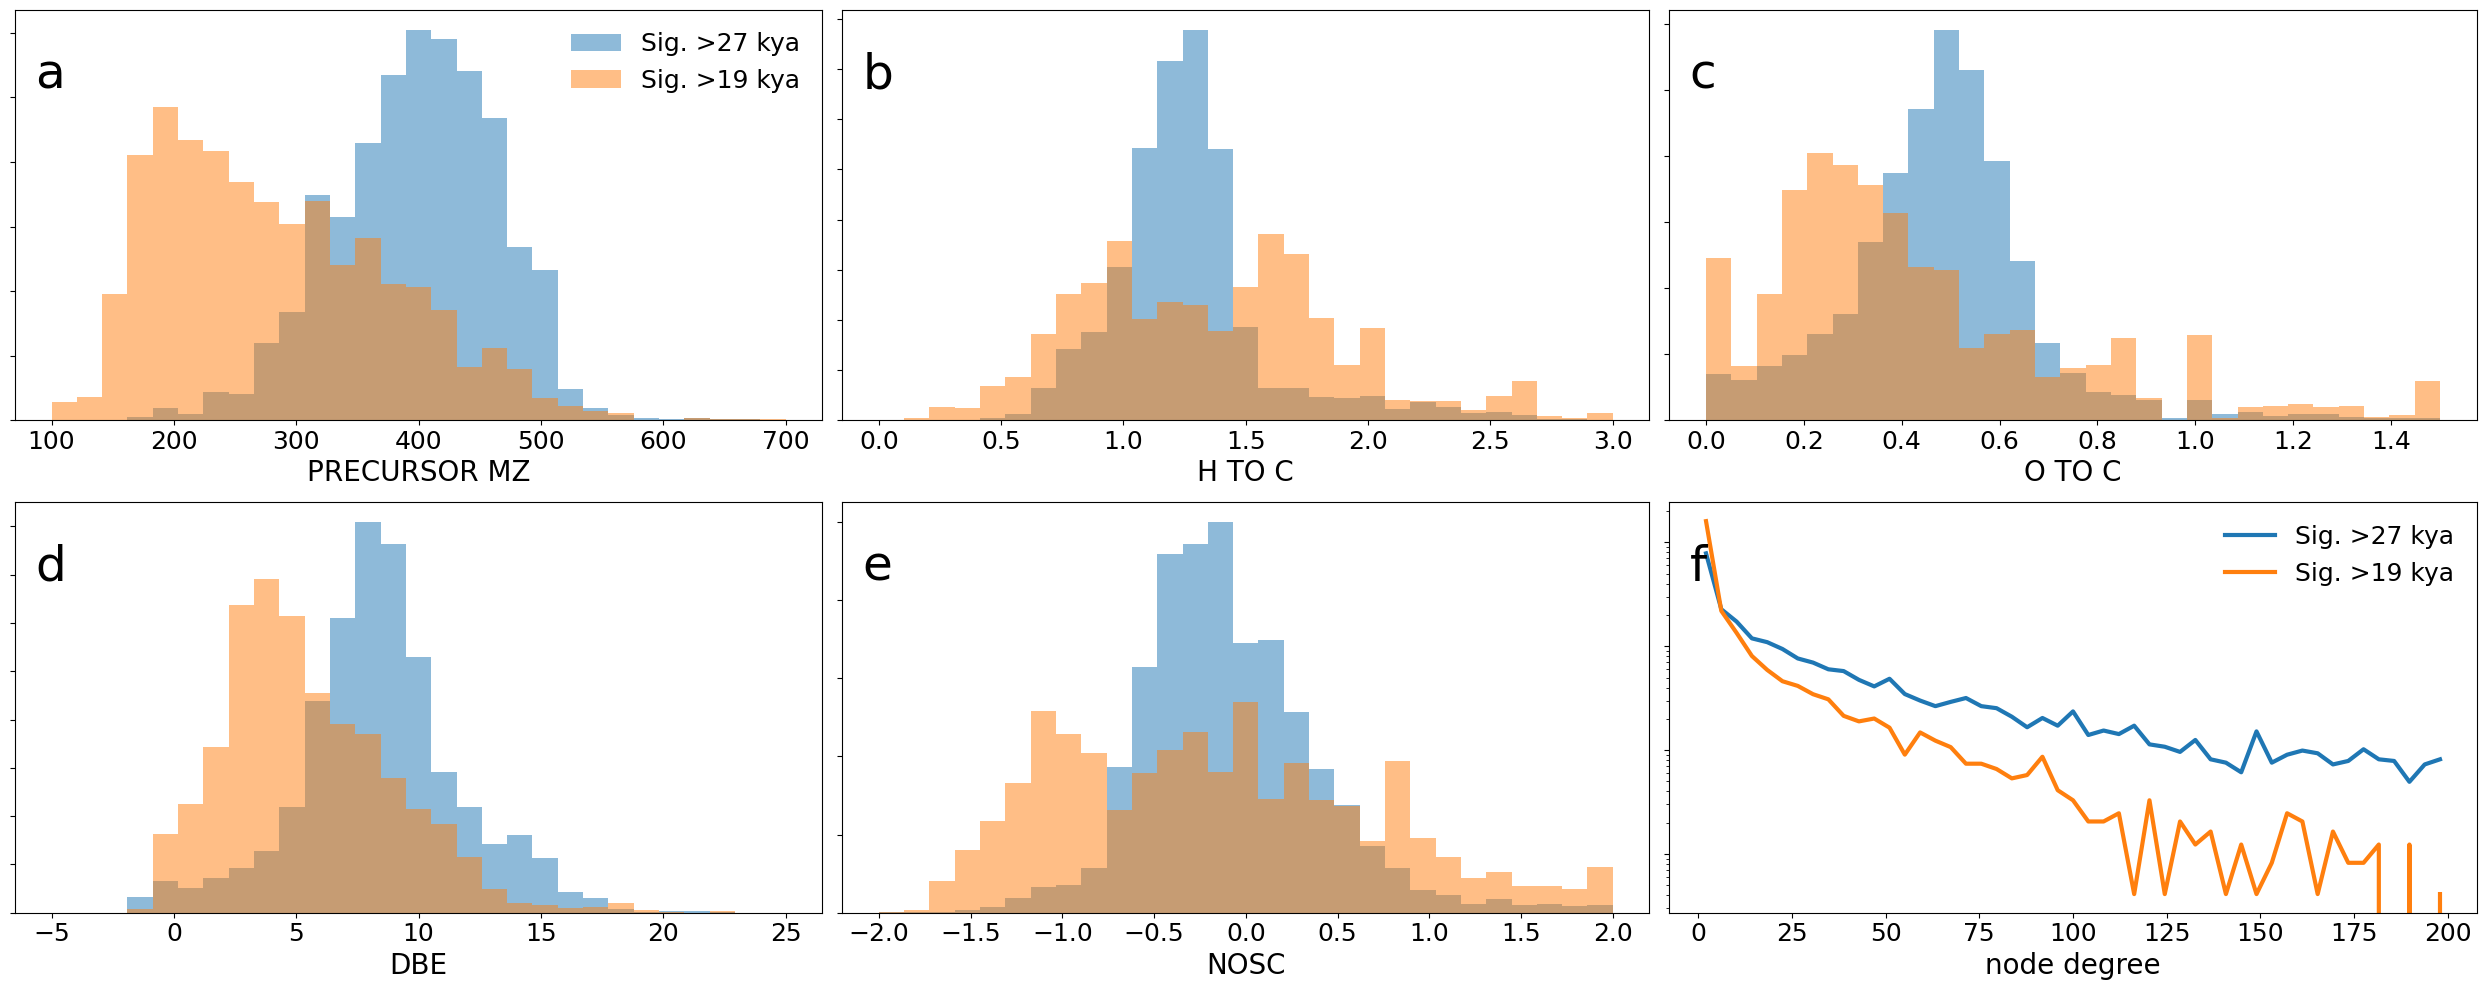

In [22]:
# --- Common Setup and Data Loading ---
# This part is run only once to load and prepare the data.
data_path = '../results/full_build_20250908_181404/permafrost results gnps2'
analysis_filename = os.path.join(data_path, 'analysis_results', 'statistical_results.csv')

# Load the data
output = pd.read_csv(analysis_filename)

# NOTE: The 'node_data' DataFrame needs to be loaded or defined before this line.
# For example: node_data = pd.read_csv('path/to/your/node_data.csv')
# As a placeholder, let's assume node_data is an empty DataFrame if it doesn't exist
if 'node_data' not in locals():
    print("Warning: 'node_data' not found. Creating an empty DataFrame.")
    # This assumes 'original_index' is the merge key. Adjust if necessary.
    node_data = pd.DataFrame({'original_index': output['original_index'].unique()})


output = pd.merge(output, node_data, on='original_index', how='left')

import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(25, 10))

gs = gridspec.GridSpec(nrows=2, ncols=3, figure=fig)

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])
# ax7 = fig.add_subplot(gs[2, 0])
# ax8 = fig.add_subplot(gs[2, 1])
# ax9 = fig.add_subplot(gs[2, 2])



# Example usage: plot something on each subplot
ax = [ax1, ax2, ax3, ax4, ax5, ax6]#, ax7, ax8, ax9]
counter = 0
terms = [('precursor_mz',100,700),('h_to_c',0,3),('o_to_c',0,1.5),('dbe',-5,25),('nosc',-2,2)]
for term in terms:
    edges = np.linspace(term[1],term[2],30)
    idx = (output['log2_foldchange'] > 1) & (output['p_value'] < 0.05)
    ax[counter].hist(output.loc[idx,term[0]],bins=edges,alpha=0.5,label='Sig. >27 kya',density=True)

    idx = (output['log2_foldchange'] < -1) & (output['p_value'] < 0.05)
    ax[counter].hist(output.loc[idx,term[0]],bins=edges,alpha=0.5,label='Sig. >19 kya',density=True)
    ax[counter].set_xlabel(term[0].replace('envnet','').replace('_',' ').upper(),fontsize=20)
    if counter == 0:
        ax[counter].legend(fontsize=18,frameon=False)
    # ax[counter].legend()
    ax[counter].set_yticklabels([])
    # increase fontsize of x tick labels
    ax[counter].tick_params(axis='x', labelsize=18)
    counter += 1

edges = np.linspace(0,200,50)
idx = (output['log2_foldchange'] > 1) & (output['p_value'] < 0.05)
up_nodes = output.loc[idx,'original_index'].to_list()
# histogram the node degree of the nodes we want
degrees = [G.degree(str(n)) for n in up_nodes]
# ax[counter].hist(degrees,bins=edges,alpha=0.5,label='Sig. >27 kya',density=True,cumulative=False)
y_data,x_data = np.histogram(degrees,bins=edges,density=True)
x_data = (x_data[1:] + x_data[:-1])/2
ax[counter].plot(x_data,y_data,'-',label='Sig. >27 kya',linewidth=3)

idx = (output['log2_foldchange'] < -1) & (output['p_value'] < 0.05)
down_nodes = output.loc[idx,'original_index'].to_list()
# histogram the node degree of the nodes we want
degrees = [G.degree(str(n)) for n in down_nodes]
# ax[counter].hist(degrees,bins=edges,alpha=0.5,label='Sig. >19 kya',density=True,cumulative=False)
y_data,x_data = np.histogram(degrees,bins=edges,density=True)
x_data = (x_data[1:] + x_data[:-1])/2
ax[counter].plot(x_data,y_data,'-',label='Sig. >19 kya',linewidth=3)
ax[counter].set_xlabel('node degree',fontsize=20)

ax[counter].legend(fontsize=18,frameon=False)
ax[counter].set_yscale('log')
ax[counter].tick_params(axis='x', labelsize=18)
# ax[counter].tick_params(axis='y', labelsize=18)
ax[counter].set_yticklabels([])
counter += 1

# add a,b,c
for i, label in enumerate(('a', 'b', 'c', 'd', 'e', 'f')):
    ax[i].text(0.025, 0.9, label, transform=ax[i].transAxes,
            fontsize=35, va='top')


plt.tight_layout()


plt.show()

(0.0, 0.07)

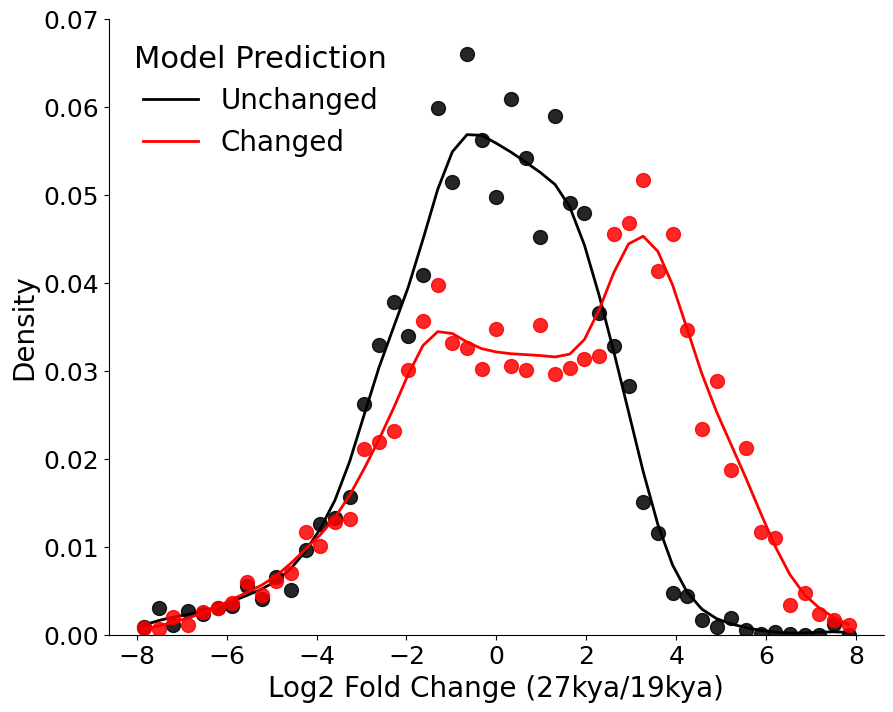

In [11]:
data_path = '../results/full_build_20250908_181404/permafrost results gnps2'
analysis_filename = os.path.join(data_path,'analysis_results','statistical_results.csv')

output = pd.read_csv(analysis_filename)#,usecols=cols)
output = pd.merge(output,node_data,on='original_index',how='left')

fig,ax = plt.subplots(figsize=(10, 8))
temp = output.copy()
temp = output[pd.notna(temp['log2_foldchange'])]
temp = temp[pd.notna(temp['predicted_unchanged_in_soil_prob'])]

# temp = df[pd.notna(temp['ms2_score'])]
idx_identified = (temp['predicted_unchanged_in_soil']==1)
edges = np.linspace(-8,8,50)
# ax.hist(df.loc[idx_identified,'log2_foldchange'],bins=edges,label='Has Library Match',alpha=0.5,density=True)
y,x = np.histogram(temp.loc[idx_identified,'log2_foldchange'],bins=edges,density=False)
x = (x[1:] + x[:-1])/2
# use gaussian to smooth
pat = np.exp(-x**2/(2*0.5**2))
smooth_y = np.convolve(y, pat, mode='same')
smooth_y /= np.sum(smooth_y)
y  = y/np.sum(y)
ax.plot(x,y,'k.',alpha=0.85,markersize=20)
ax.plot(x,smooth_y,'k-',label='Unchanged',alpha=1,linewidth=2)
# ax.hist(df['log2_foldchange'],bins=edges,label='All Nodes',alpha=0.5,density=True)
y,x = np.histogram(temp.loc[~idx_identified,'log2_foldchange'],bins=edges,density=False)
x = (x[1:] + x[:-1])/2
# use gaussian to smooth

smooth_y = np.convolve(y, pat, mode='same')
smooth_y /= np.sum(smooth_y)
y  = y/np.sum(y)
ax.plot(x,y,'r.',alpha=0.85,markersize=20)
ax.plot(x,smooth_y,'r-',label='Changed',alpha=1,linewidth=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Log2 Fold Change (27kya/19kya)',fontsize=20)
ax.set_ylabel('Density',fontsize=20)
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)
ax.legend(frameon=False,fontsize=20,loc='upper left',title='Model Prediction',title_fontsize=22)
ax.set_ylim(0,0.07)


(0.0, 0.1)

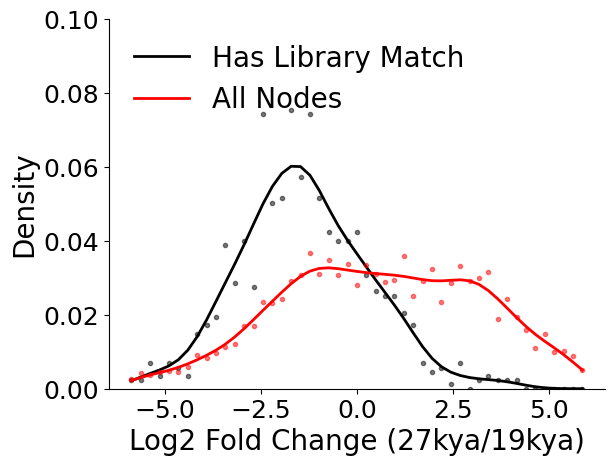

In [ ]:
data_path = '../results/full_build_20250908_181404/permafrost results gnps2'
analysis_filename = os.path.join(data_path,'analysis_results','statistical_results.csv')

output = pd.read_csv(analysis_filename)#,usecols=cols)
output = pd.merge(output,node_data,on='original_index',how='left')

fig,ax = plt.subplots(figsize=(10,8))
temp = output.copy()
temp = output[pd.notna(temp['log2_foldchange'])]
# temp = df[pd.notna(temp['ms2_score'])]
idx_identified = (pd.notna(temp['inchi_key']))# & (pd.notna(df['ms2_score'])) #& (df['p_value'] < 0.05)
edges = np.linspace(-6,6,50)
# ax.hist(df.loc[idx_identified,'log2_foldchange'],bins=edges,label='Has Library Match',alpha=0.5,density=True)
y,x = np.histogram(temp.loc[idx_identified,'log2_foldchange'],bins=edges,density=False)
x = (x[1:] + x[:-1])/2
# use gaussian to smooth
pat = np.exp(-x**2/(2*0.5**2))
smooth_y = np.convolve(y, pat, mode='same')
smooth_y /= np.sum(smooth_y)
y  = y/np.sum(y)
ax.plot(x,y,'k.',alpha=0.5)
ax.plot(x,smooth_y,'k-',label='Has Library Match',alpha=1,linewidth=2)
# ax.hist(df['log2_foldchange'],bins=edges,label='All Nodes',alpha=0.5,density=True)
y,x = np.histogram(temp['log2_foldchange'],bins=edges,density=False)
x = (x[1:] + x[:-1])/2
# use gaussian to smooth

smooth_y = np.convolve(y, pat, mode='same')
smooth_y /= np.sum(smooth_y)
y  = y/np.sum(y)
ax.plot(x,y,'r.',alpha=0.5)
ax.plot(x,smooth_y,'r-',label='All Nodes',alpha=1,linewidth=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Log2 Fold Change (27kya/19kya)',fontsize=20)
ax.set_ylabel('Density',fontsize=20)
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)
ax.legend(frameon=False,fontsize=20,loc='upper left')
ax.set_ylim(0,0.1)

In [78]:
output['compound_name'] = output['compound_name'].fillna('')
output[output['compound_name'].str.contains('caffe')]

,original_index,mean-20M,mean-55M,median-20M,median-55M,standard_error-20M,standard_error-55M,std_dev-20M,std_dev-55M,p_value,...,control_group,treatment_group,precursor_mz,inchi_key,compound_name,smiles,NPC#pathway,NPC#superclass,NPC#class,predicted_formula
6986,272913,1.564964e+08,4.203440e+07,1.530566e+08,4.307872e+07,3.486557e+06,1.084908e+06,6.038894e+06,1.879116e+06,0.000006,...,20M,55M,179.034058,QAIPRVGONGVQAS-DUXPYHPUSA-N,caffeic acid,O=C(O)/C=C/c1ccc(O)c(O)c1,NaN,NaN,NaN,C9H8O4
6990,273021,1.564964e+08,4.203440e+07,1.530566e+08,4.307872e+07,3.486557e+06,1.084908e+06,6.038894e+06,1.879116e+06,0.000006,...,20M,55M,179.034132,QAIPRVGONGVQAS-DUXPYHPUSA-N,caffeic acid,O=C(O)/C=C/c1ccc(O)c(O)c1,Shikimates and Phenylpropanoids,Phenylpropanoids (C6-C3),Cinnamic acids and derivatives,C9H8O4


In [104]:
# ttest identied vs all using temp
from scipy.stats import ttest_ind
t,p = ttest_ind(temp.loc[idx_identified,'log2_foldchange'],temp['log2_foldchange'])
print(p,t)

5.051733186133322e-37 -12.74826528912092


(10000.0, 10000000000.0)

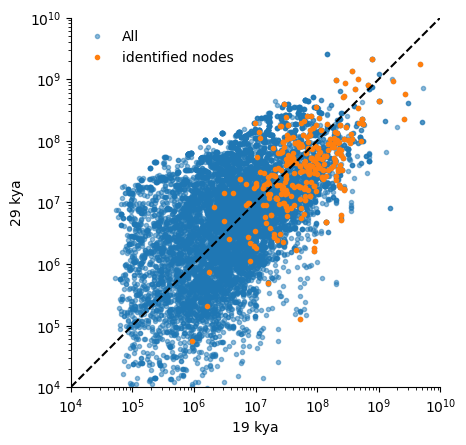

In [63]:
fig,ax = plt.subplots(
)
idx_identified = (pd.notna(df['envnet_smiles_identity'])) & (pd.notna(df['ms2_score'])) & (df['p_value'] < 0.05)

ax.plot(df['mean-19 kya'],df['mean-27 kya'],'.',label='All',alpha=0.5)
ax.plot(df.loc[idx_identified,'mean-19 kya'],df.loc[idx_identified,'mean-27 kya'],'.',label='identified nodes')
ax.plot([1e4,1e10],[1e4,1e10],'k--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('19 kya')
ax.set_ylabel('29 kya')
# legend with no box
ax.legend(frameon=False)
# remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# set aspect ratio to be equal

ax.axes.set_aspect('equal')
ax.set_xlim(1e4,1e10)
ax.set_ylim(1e4,1e10)

In [52]:


def calc_formula_diff(formula1,formula2):
    # parse each chemical formula using regular expression
    import re
    try:
        elements = re.findall(r'([A-Z][a-z]*)(\d*)', formula1)
        elements_dict1 = {el: int(num) if num else 1 for el, num in elements}
        elements = re.findall(r'([A-Z][a-z]*)(\d*)', formula2)
        elements_dict2 = {el: int(num) if num else 1 for el, num in elements}
        # get the difference in the number of elements
        diff = {}
        for key in elements_dict1.keys():
            diff[key] = elements_dict1[key] - elements_dict2.get(key,0)
        for key in elements_dict2.keys():
            if key not in elements_dict1:
                diff[key] = -1*elements_dict2[key]
        # return the difference as a forumla ordered C,H,N,O,S,P
        elements_vec = ['C','H','N','O','S','P']
        diff = [diff.get(el,0) for el in elements_vec]
        formula_out = ''
        for i,el in enumerate(elements_vec):
            if diff[i] != 0:
                formula_out += el + str(diff[i])
        # formula = 'C%dH%dN%dO%dS%dP%d'%tuple(diff)
        # drop all the ones that are zero
        # formula = re.sub(r'([A-Z][a-z]*)(0)', '', formula)
        # print(formula)
    except:
        formula_out = ''
        print(formula1,formula2)
    return formula_out

df.dropna(subset=['envnet_formula'],inplace=True)    
identified_node_ids = df.loc[idx_identified,'envnet_node_id'].tolist()
idx_identified = pd.notna(df['envnet_smiles_identity'])
print(sum(idx_identified))

neighbors = []
for node_id in identified_node_ids:
    n = list(G.neighbors(node_id))
    neighbor_df = df.loc[df['envnet_node_id'].isin(n)]
    idx = df['envnet_node_id']==node_id
    identified_formula = df.loc[idx,'envnet_formula'].values[0]
    identified_o_to_c = df.loc[idx,'envnet_o_to_c'].values[0]
    if identified_formula is None:
        continue
    neighbor_df['identified_formula'] = identified_formula
    neighbor_df['identified_o_to_c'] = identified_o_to_c
    # calculate hte formula difference
    # neighbor_df.dropna(subset=['envnet_formula'],inplace=True)
    idx = neighbor_df['envnet_formula'] != neighbor_df['identified_formula']
    if sum(idx) == 0:
        continue
    neighbor_df = neighbor_df[idx]
    neighbor_df['formula_diff'] = neighbor_df.apply(lambda x: calc_formula_diff(x['envnet_formula'],x['identified_formula']),axis=1)
    neighbors.append(neighbor_df[['envnet_node_id','envnet_formula','envnet_o_to_c','identified_o_to_c','identified_formula','formula_diff','mean-19 kya','mean-27 kya','p_value','log2_foldchange','envnet_smiles_identity']])

neighbors = pd.concat(neighbors)
neighbors['o_to_c_ratio'] = np.log2(neighbors['envnet_o_to_c'] / neighbors['identified_o_to_c'])
neighbors['formula_diff'].value_counts().head(20)


780


C1H2O1        602
O1            413
C-1H-2O-1     408
O-1           301
C2H2O3        214
H-2O1         188
C1O1          123
C1H-2O3       105
C1O3           96
C3H2O5         85
C-6H-2N2O1     76
C-3H4S1        71
C3H4O6         68
C1O2           67
C-4H2O-1S1     67
O2             66
C2H4O4         65
H2O-1          65
C1H4O-1        58
C2O3           56
Name: formula_diff, dtype: int64

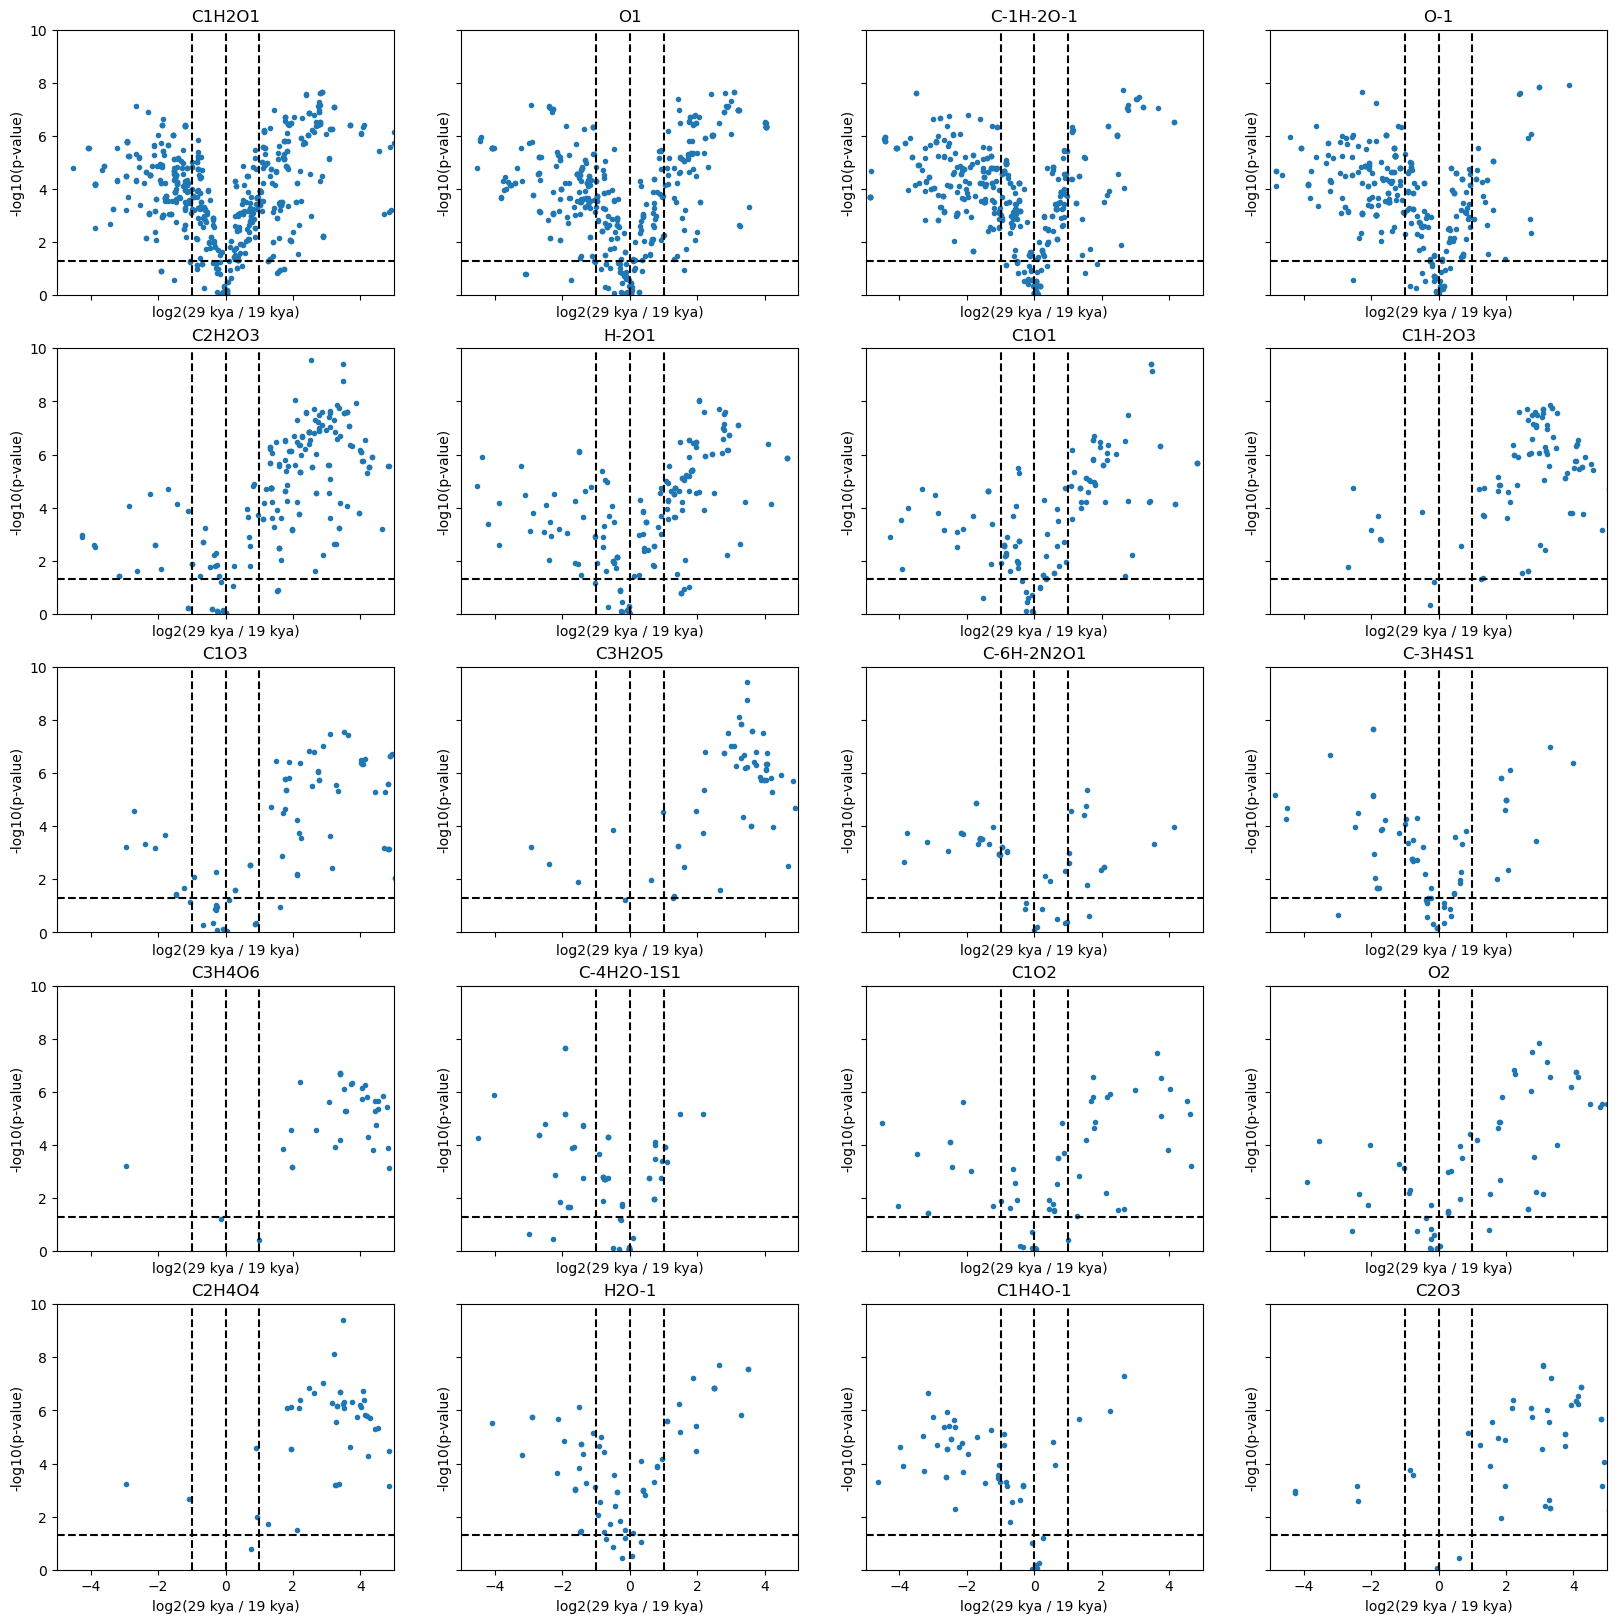

In [53]:
import scipy.stats as stats
top_diff = neighbors.value_counts('formula_diff').head(20).index.tolist()
fig,ax = plt.subplots(nrows=5,ncols=4,figsize=(20,20),sharex=True,sharey=True)
ax = ax.flatten()
for i,diff in enumerate(top_diff):
    idx = neighbors['formula_diff'] == diff
    x = neighbors.loc[idx,'mean-19 kya']
    y = neighbors.loc[idx,'mean-27 kya']
    # calculate p-value
    fc = np.log2(y/x)
    p = neighbors.loc[idx,'p_value']
    # ax[i].hist(fc,bins=np.linspace(-5,5,50),density=True)
    # p,t = stats.ttest_rel(fc,np.zeros_like(fc))
    # if p<0.05:
    ax[i].plot(fc,-1*np.log10(p),'.')
    # ax[i].set_xscale('log')
    # ax[i].set_yscale('log')
    ax[i].set_title(diff)
    ax[i].set_xlim(-5,5)
    ax[i].set_ylim(0,10)
    ax[i].set_xlabel('log2(29 kya / 19 kya)')
    ax[i].set_ylabel('-log10(p-value)')
    ax[i].axhline(-1*np.log10(0.05),color='k',linestyle='--')
    ax[i].axvline(0,color='k',linestyle='--')
    ax[i].axvline(1,color='k',linestyle='--')
    ax[i].axvline(-1,color='k',linestyle='--')

    # ax[i].plot([1e4,1e10],[1e4,1e10],'k--')
    # ax[i].set_xlabel('19 kya')
    # ax[i].set_ylabel('29 kya')
    # ax[i].set_xlim(1e4,1e10)
    # ax[i].set_ylim(1e4,1e10)
    # ax[i].set_aspect('equal')

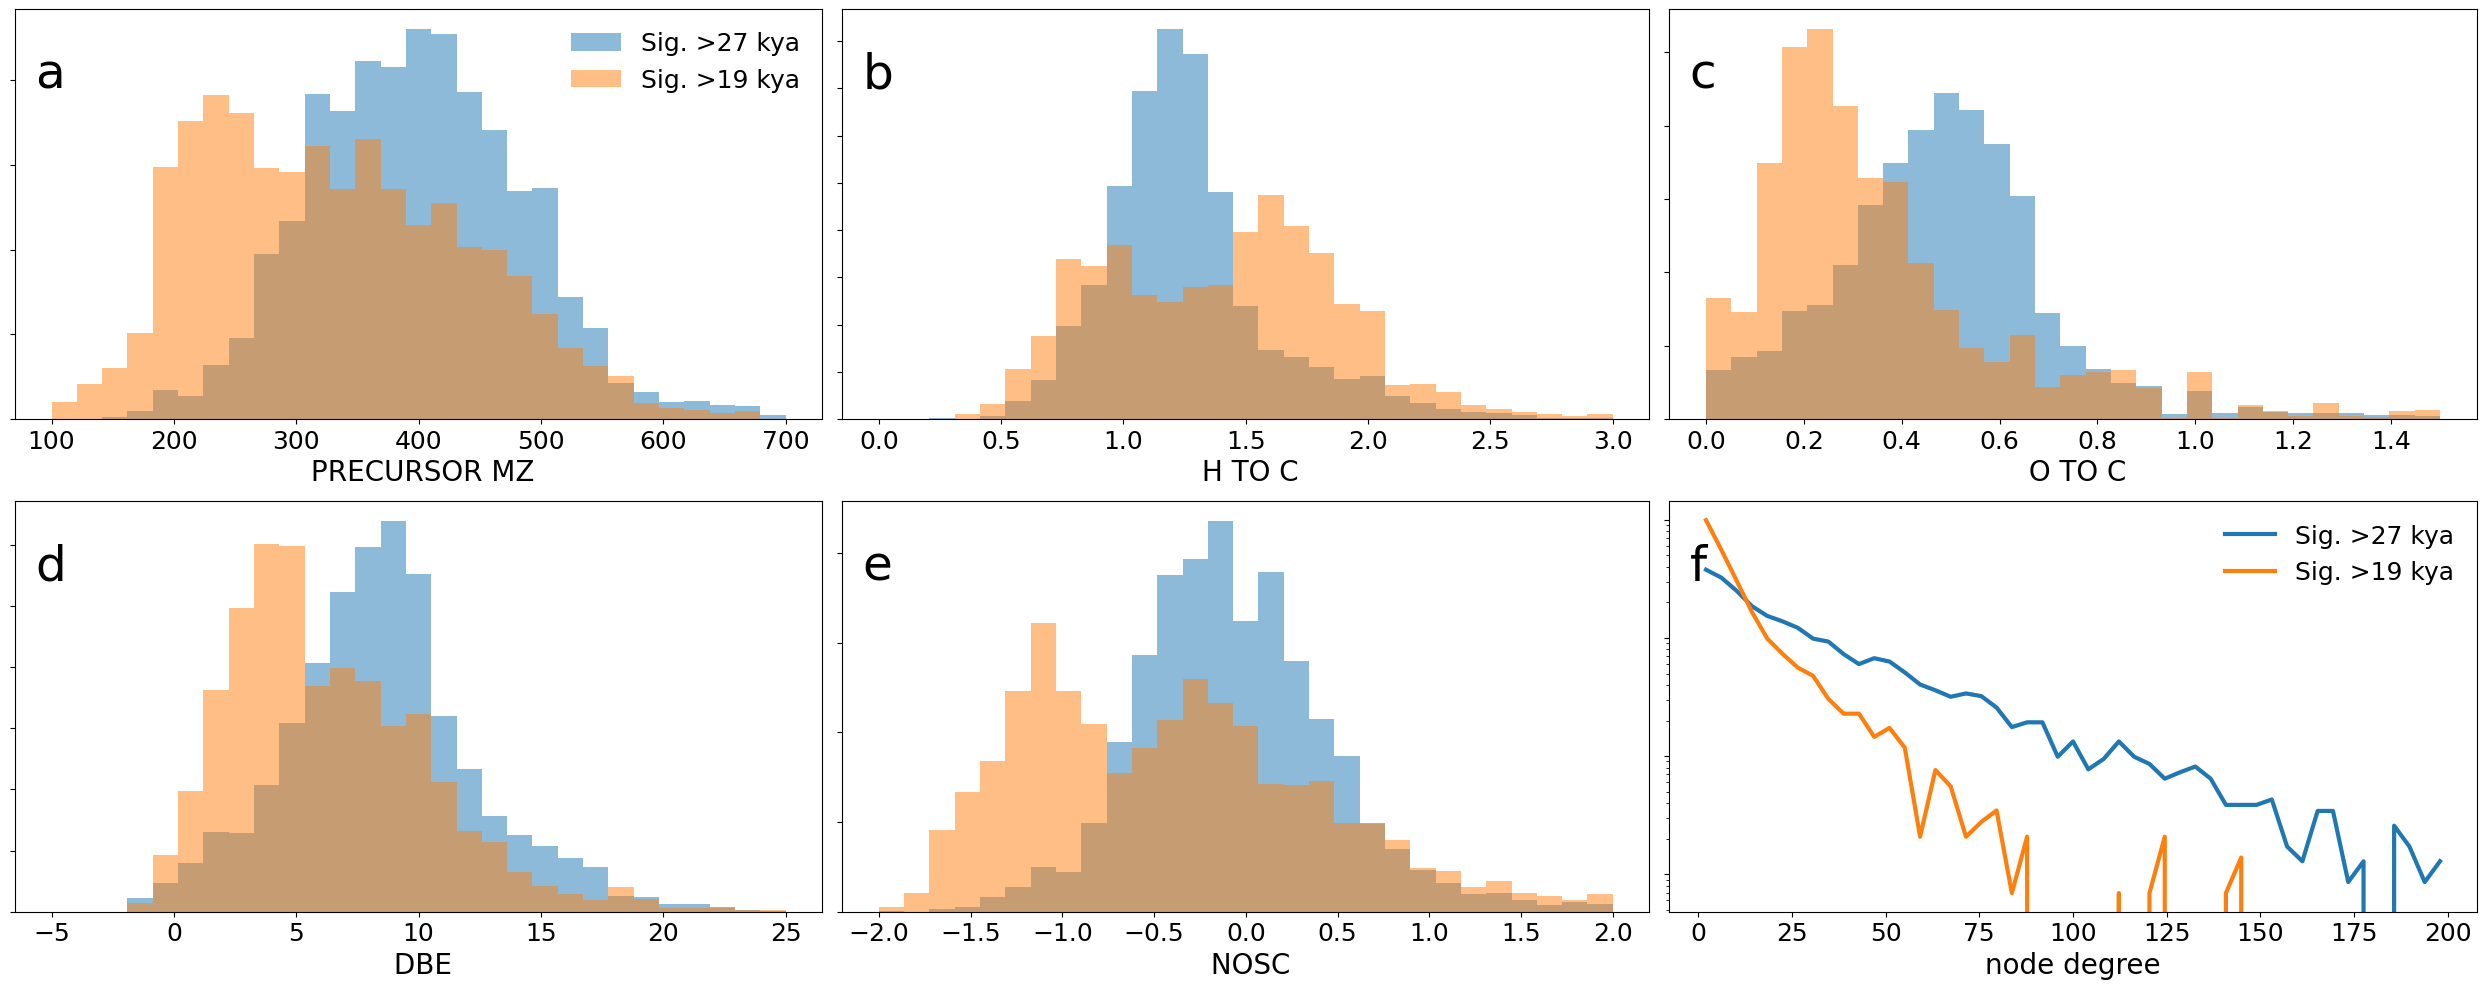

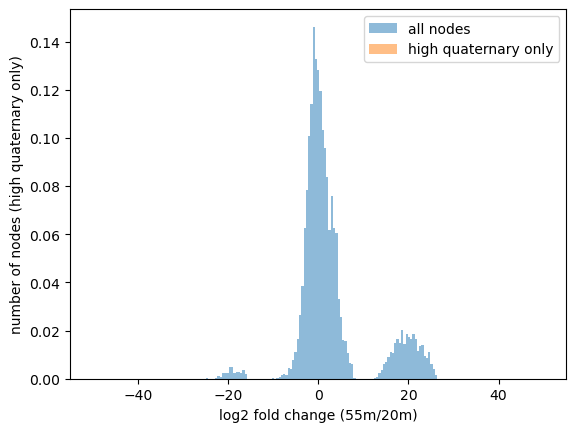

In [ ]:

import seaborn as sns
fig,ax = plt.subplots(
)
edges = np.linspace(-50,50,200)
ax.hist(df['log2_foldchange'],bins=edges,density=True,alpha=0.5,label='all nodes')
# sns.kdeplot(df['log2_foldchange'],ax=ax,label='all nodes')
# sns.histplot(df['log2_foldchange'],ax=ax,label='all nodes')

df = df[df['envnet_high_quaternary']==True]

ax.hist(df['log2_foldchange'],bins=edges,density=True,alpha=0.5,label='high quaternary only')
# sns.kdeplot(df['log2_foldchange'],ax=ax,label='high quaternary only')
# sns.histplot(df['log2_foldchange'],ax=ax,label='high quaternary only')
ax.set_xlabel('log2 fold change (55m/20m)')
ax.set_ylabel('number of nodes (high quaternary only)')
ax.legend()

In [4]:
# df = pd.read_csv('/global/cfs/cdirs/metatlas/projects/carbon_network/public_and_internal_files_with_massive_and_redu.tsv', sep='\t')
# df = df[df['SampleType']=='plant']
# df = df[~df['buddy'].str.contains('qc',case=False)]
# df = df[~df['buddy'].str.contains('blank',case=False)]
# out_dir = '/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data'
# temp_files = df['h5'].tolist()
# files = []
# for f in temp_files:
#     base_dir = os.path.dirname(f)
#     base_name = os.path.basename(f)
#     new_dir = os.path.join(out_dir,base_dir)
#     new_name = os.path.join(new_dir,base_name)
#     files.append(new_name)
#     if not os.path.isfile(new_name):
#         print('File Not Found!')
#         print(new_name)
#         print(f)
# files_data = pd.DataFrame(files,columns=['filename'])
# files = files_data['filename'].tolist()


In [5]:
# collect and merge required data and metadata
node_data = at.graph_to_df()
node_atlas = at.make_node_atlas(node_data, rt_range)
merged_node_data = at.merge_spectral_data(node_data)
# files_data = at.get_files_df(exp_dir)
# files = files_data['filename'].tolist()

INFO:root:Processing envnet_original_spectra.mgf
INFO:root:Processing envnet_mdm_spectra.mgf


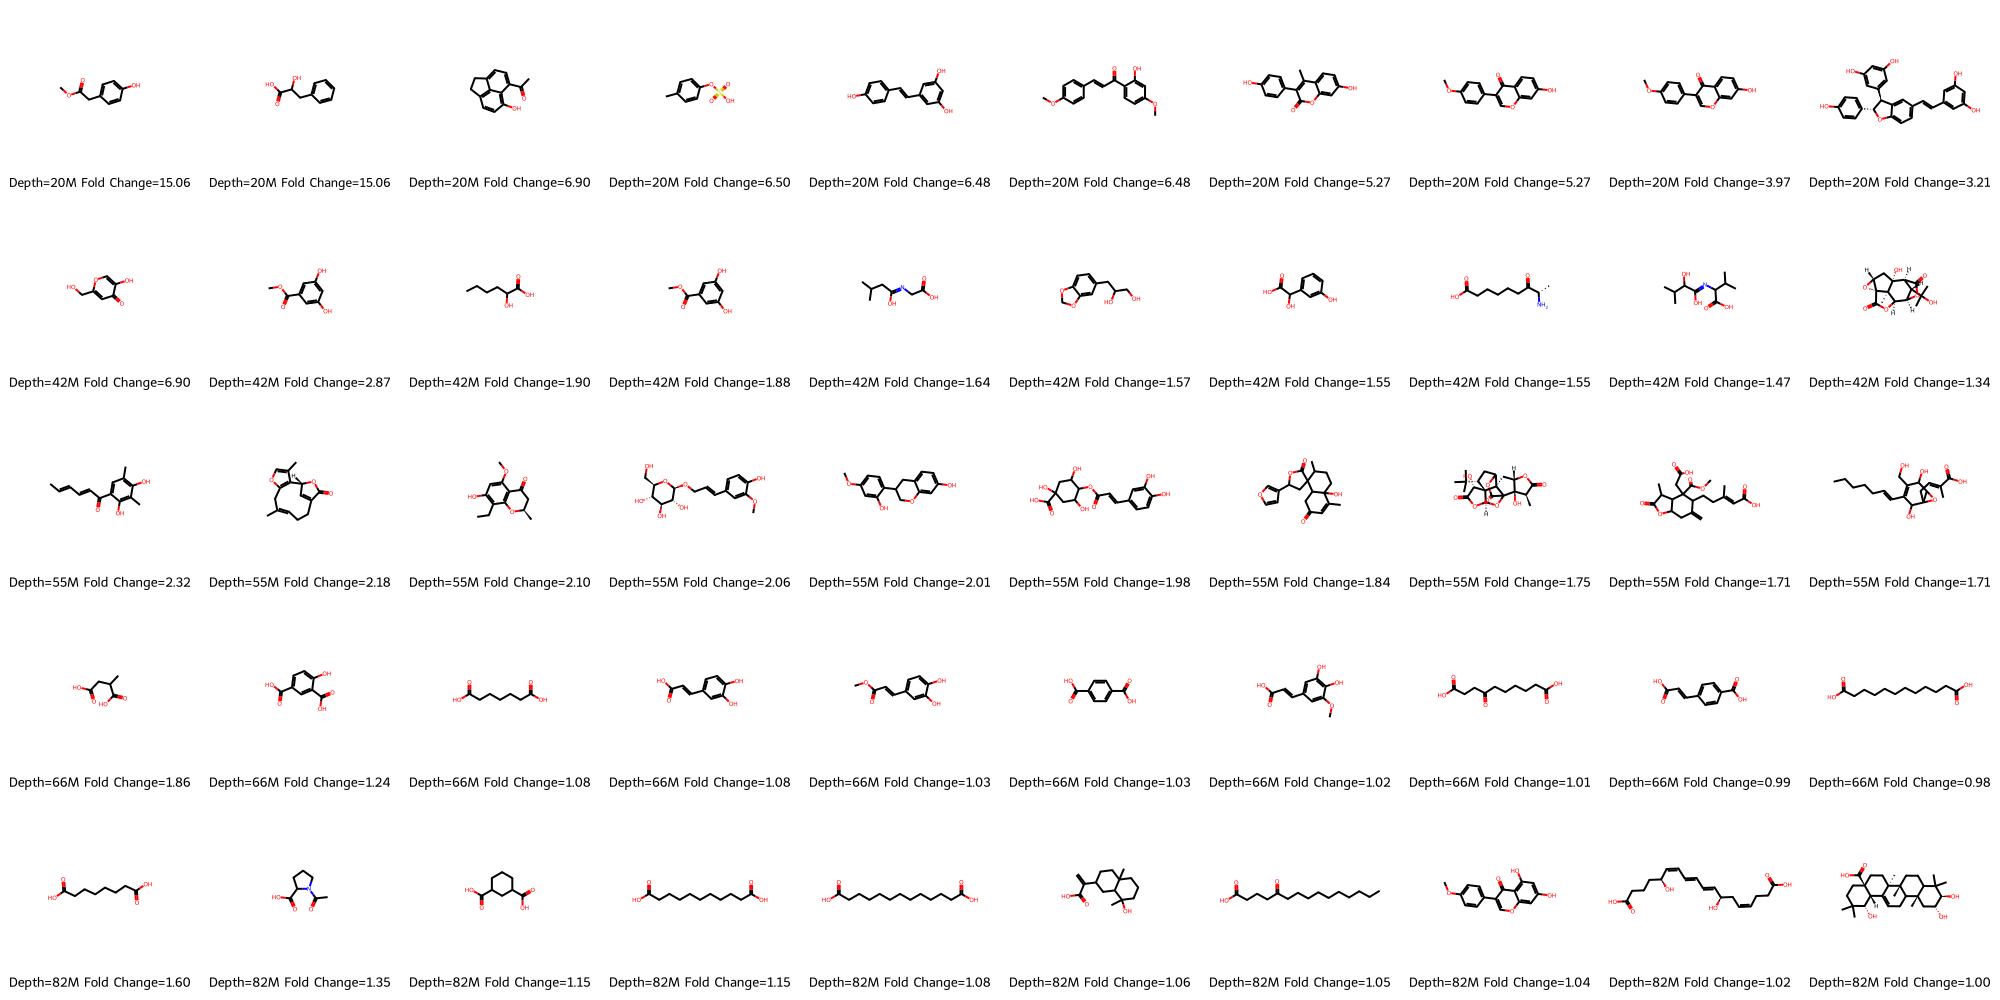

In [275]:
# Get the top 5 nodes from each depth

temp = ms1_data[ms1_data['time']=='T0'].copy()
temp = temp[temp['node_id'].isin(out_node['node_id'].unique())]

ms2_nodes = ms2_data.loc[(ms2_data['score']>0.7) & (ms2_data['matches']>5),'node_id'].unique()
temp = temp[temp['node_id'].isin(ms2_nodes)]

# idx = pd.notna(node_data['smiles_identity'])
idx = (node_data['max_score_identity']>0.7) & (node_data['max_matches_identity']>5)
id_nodes = node_data.loc[idx, 'node_id'].unique().astype(str)
temp = temp[temp['node_id'].astype(str).isin(id_nodes)]

p = pd.pivot_table(temp,values='peak_area',index=['lcmsrun_observed','sampletype','depth','time'],columns='node_id',fill_value=1)
# p = p.loc[:,p.min()>1e6]
s = p.sum(axis=1)
p_n = p.div(s, axis=0)
p_m = p.sum(axis=0).mean()
p = p_n * p_m


p = p.groupby(['depth']).mean()


from rdkit import Chem
from rdkit.Chem import Draw
top_n = 10
my_mols = []
legend_str = []
for depth in p.index:
    d_profile = p.loc[depth]
    other_profiles = p.drop(depth).max(axis=0)
    d_profile = d_profile / other_profiles
    
    top_nodes = d_profile.sort_values(ascending=False)
    top_nodes = top_nodes.iloc[:top_n]
    top_nodes_index = top_nodes.index.astype(str)
    for fold_change in top_nodes.tolist():
        legend_str.append('Depth=%s Fold Change=%0.2f'%(depth,fold_change))
    s = node_data[node_data['node_id'].isin(top_nodes_index)]['smiles_identity'].tolist()
    for ss in s:
        my_mols.append(Chem.MolFromSmiles(ss))

Draw.MolsToGridImage(my_mols,molsPerRow=top_n,subImgSize=(200,200),legends=legend_str)


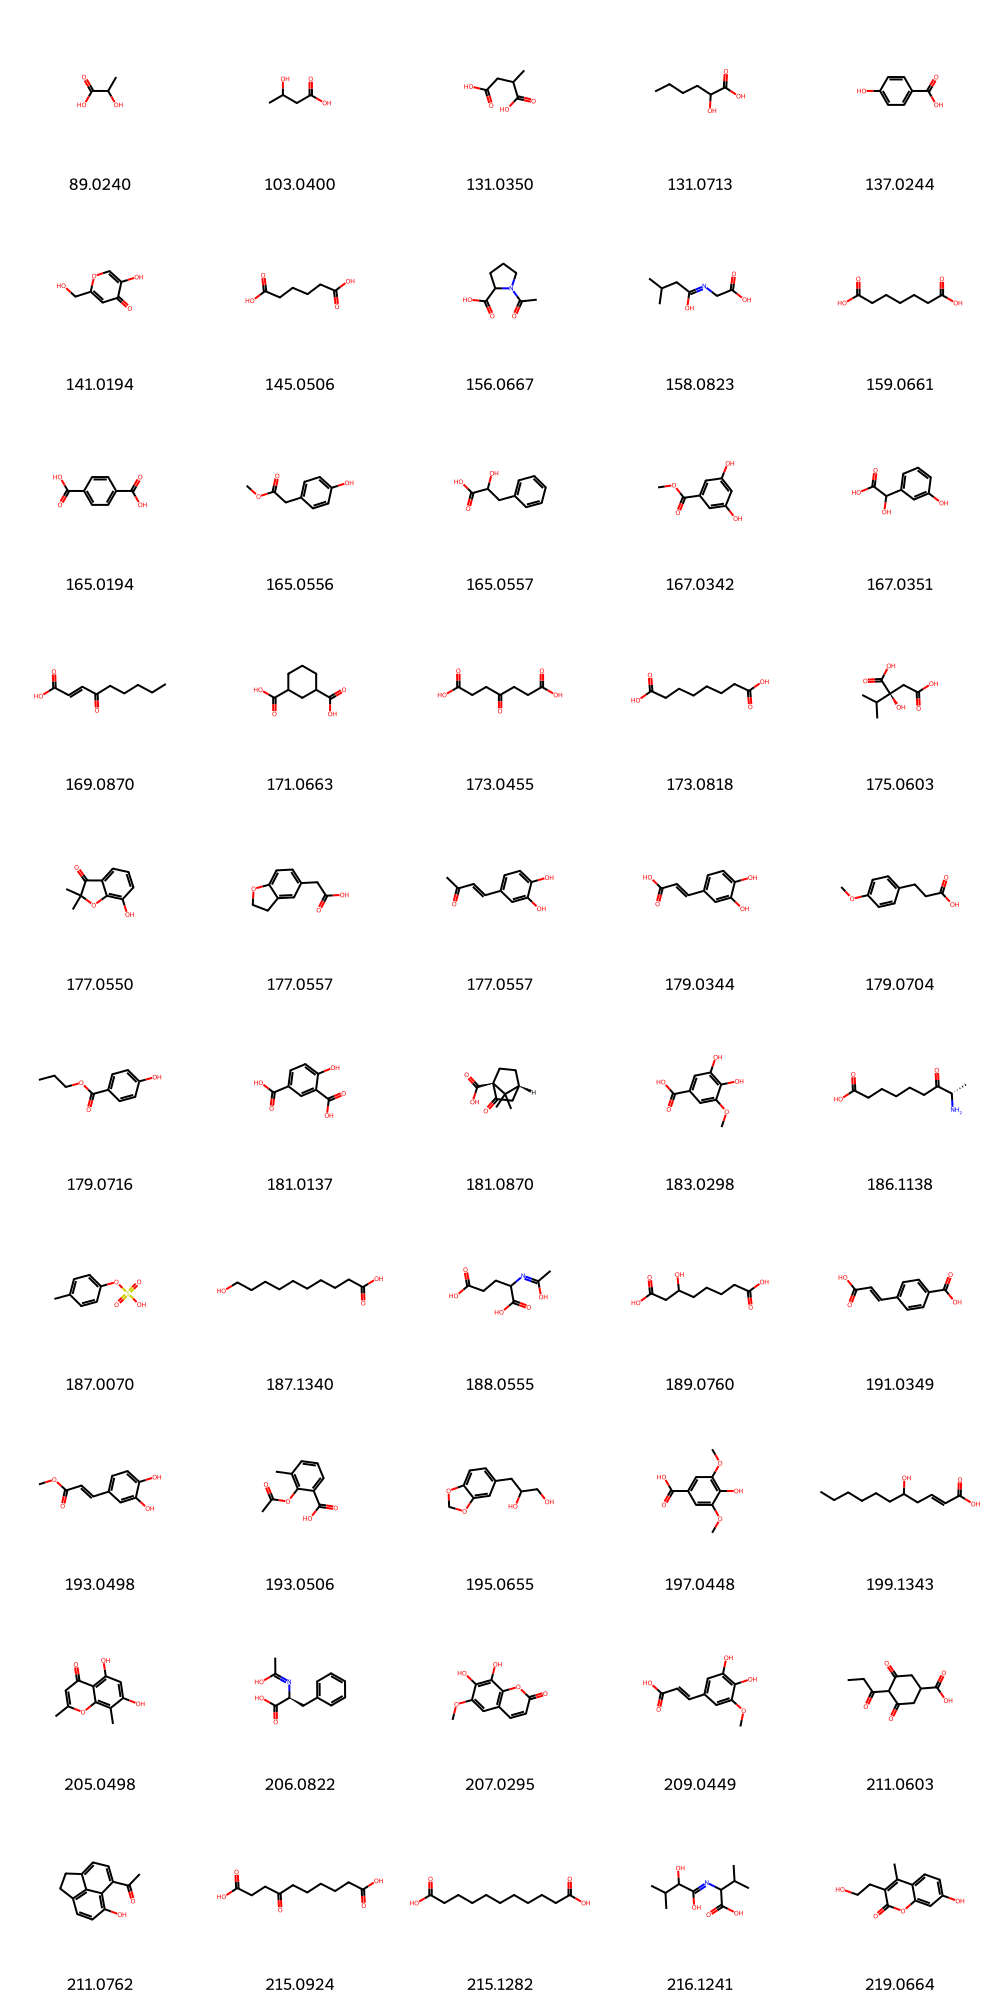

In [321]:
df = p>10
idx = df.min(axis=0)==True

df = df.loc[:,idx]
my_mols = []


s = node_data[node_data['node_id'].isin(df.columns.astype(str))]['smiles_identity'].tolist()
leg_str = node_data[node_data['node_id'].isin(df.columns.astype(str))]['class_results'].tolist()
leg_str = node_data[node_data['node_id'].isin(df.columns.astype(str))]['precursor_mz'].tolist()
leg_str = ['%.4f'%l for l in leg_str]

mw = node_data[node_data['node_id'].isin(df.columns.astype(str))]['precursor_mz'].tolist()
sorted_idx = np.argsort(mw)
s = [s[i] for i in sorted_idx]
leg_str = [leg_str[i] for i in sorted_idx]

# drop duplicates smiles
idx = pd.Series(s).duplicated(keep='first')
s = [s[i] for i in range(len(s)) if not idx[i]]
leg_str = [leg_str[i] for i in range(len(leg_str)) if not idx[i]]


my_mols = []

for ss in s:
    my_mols.append(Chem.MolFromSmiles(ss))
Draw.MolsToGridImage(my_mols,molsPerRow=5,subImgSize=(200,200),legends=leg_str)

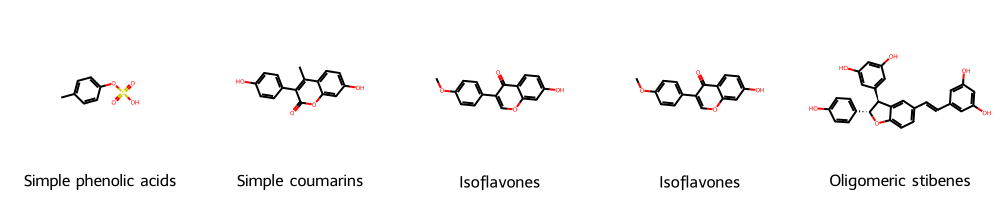

In [314]:
df = p>1e6
idx1 = df.loc['20M']==True
idx2 = df.drop('20M').max(axis=0)==False
idx = idx1 & idx2
df = df.loc[:,idx]
my_mols = []
s = node_data[node_data['node_id'].isin(df.columns.astype(str))]['smiles_identity'].tolist()
leg_str = node_data[node_data['node_id'].isin(df.columns.astype(str))]['class_results'].tolist()

for ss in s:
    my_mols.append(Chem.MolFromSmiles(ss))
Draw.MolsToGridImage(my_mols,molsPerRow=5,subImgSize=(200,200),legends=leg_str)

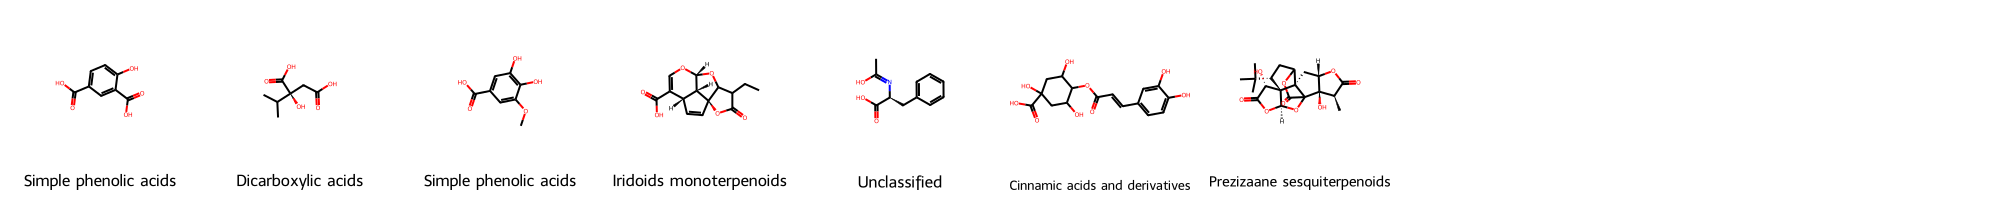

In [313]:
df = p>1e6
idx1 = df.loc['20M']==False
idx2 = df.drop('20M').min(axis=0)==True
idx = idx1 & idx2
df = df.loc[:,idx]
my_mols = []
node_data['class_results'].fillna('Unclassified',inplace=True)
s = node_data[node_data['node_id'].isin(df.columns.astype(str))]['smiles_identity'].tolist()
leg_str = node_data[node_data['node_id'].isin(df.columns.astype(str))]['class_results'].tolist()
for ss in s:
    my_mols.append(Chem.MolFromSmiles(ss))
Draw.MolsToGridImage(my_mols,molsPerRow=10,subImgSize=(200,200),legends=leg_str)
# df

In [18]:
ms2_data['temp'] = 1
temp_node_data = node_data[['node_id','class_results','class_results_propagated']].copy()
temp_node_data['class_results'].fillna('Unclassified',inplace=True)
temp_node_data['class_results_propagated'].fillna('Unclassified',inplace=True)
ms2_data['node_id'] = ms2_data['node_id'].astype(str)
# temp_node_data['class_results_propagated'] = temp_node_data['class_results_propagated'].apply(lambda x: 'Terpenoid' if 'terpenoid' in x.lower() else x)
temp = pd.merge(temp_node_data,ms2_data[['node_id','temp','environment']],on='node_id',how='left')
num_envs = pd.pivot_table(temp,index=['node_id','class_results','class_results_propagated'],columns=['environment'],values='temp',aggfunc='count')
num_envs.fillna(0,inplace=True)
num_envs[num_envs>0] = 1
num_envs = num_envs.astype(int)
num_envs['num_envs'] = num_envs.sum(axis=1)
num_envs.to_csv('../../data/num_environment_node_data.csv')
num_envs

,,environment,IHSS Reference Standards,agricultural soil,coastal sea water,desert sand,forest soil,fresh water,groundwater,humic lake,leachate,peat soil,permafrost,river water,sea water,soil,stream sediment,tropical soil,vegetable garden soil,num_envs
node_id,class_results,class_results_propagated,,,,,,,,,,,,,,,,,,
0.0,Unclassified,Unclassified,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
10.0,Unclassified,Unclassified,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,3
100.0,Dicarboxylic acids,Dicarboxylic acids,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2
10000.0,Unclassified,Unclassified,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,3
10004.0,Unclassified,Cinnamic acids and derivatives,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995.0,Unclassified,Unclassified,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
9996.0,Unclassified,Unclassified,0,0,1,1,1,0,0,0,0,0,1,1,1,0,0,1,0,7
9997.0,Unclassified,Unclassified,0,1,1,1,1,0,0,0,0,1,1,1,1,1,0,1,1,11


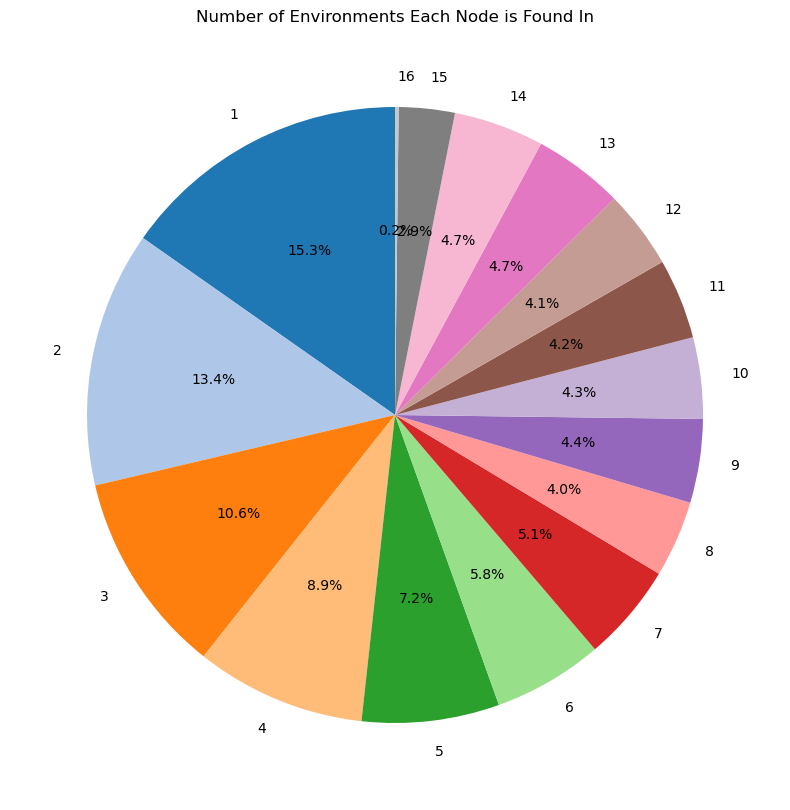

In [19]:
# make a pie chart of the number of environments each node is found in
def make_pie(num_envs):
    num_envs = num_envs[num_envs['num_envs']>0]
    num_envs = num_envs.groupby('num_envs').size().reset_index().rename(columns={0:'count'})
    num_envs['num_envs'] = num_envs['num_envs'].astype(str)
    # num_envs = num_envs.sort_values('num_envs')
    num_envs['num_envs'] = num_envs['num_envs'].astype(str)
    num_envs = num_envs.set_index('num_envs')

    # use a colormap with more colors
    colors = plt.cm.tab20.colors


    num_envs.plot.pie(y='count',figsize=(10,10),autopct='%1.1f%%',startangle=90,colors=colors)
    plt.ylabel('')
    plt.title('Number of Environments Each Node is Found In')
    # remove the legend
    plt.legend().remove()
    plt.savefig('num_environments_pie_chart.pdf',bbox_inches='tight')
    return num_envs

g = make_pie( num_envs)

In [35]:
(179.5/40)

4.4875

In [31]:
(1+1.65+1.7) / 1.6

2.7187499999999996

KruskalResult(statistic=474.9010159930767, pvalue=1.1419543244375703e-91)
SignificanceResult(statistic=-0.18295767526745443, pvalue=3.6211371304452326e-76)


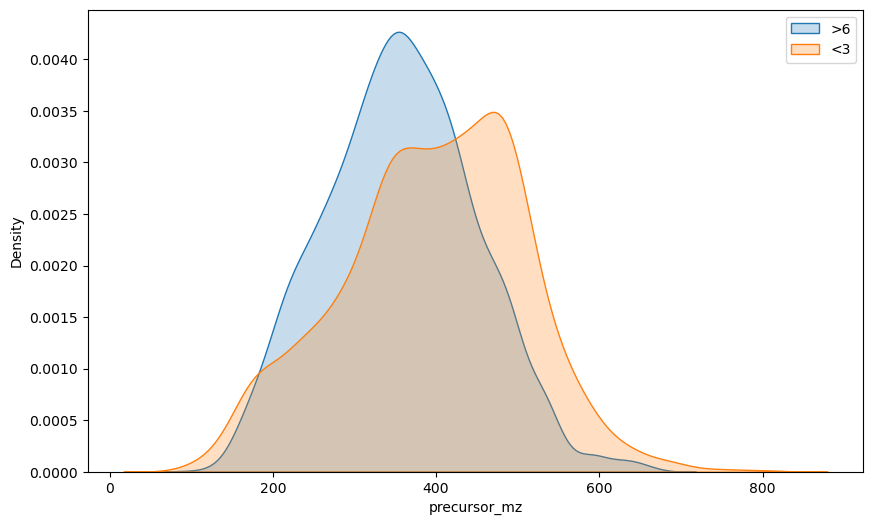

In [23]:
import seaborn as sns
g = num_envs.copy()
g.reset_index(inplace=True)
g = g[['node_id','num_envs']]
g = pd.merge(g,node_data[['node_id','precursor_mz']],on='node_id',how='left')
g = g[g['num_envs']>0]
g = g[g['precursor_mz']>0]
# as a function of num_envs plot the precursor_mz distribution
fig, ax = plt.subplots(1,1,figsize=(10,6))
# g.boxplot(column='precursor_mz',by='num_envs',ax=ax)
idx = g['num_envs']>6
sns.kdeplot(g.loc[idx,'precursor_mz'],label='>6',shade=True)
idx = g['num_envs']<3
sns.kdeplot(g.loc[idx,'precursor_mz'],label='<3',shade=True)
plt.legend()
# highlight the lower and upper 10% of the confidence interval
# regression plot with confidence interval

# sns.regplot(x='num_envs',y='precursor_mz',data=g,ax=ax)
# plt.title('Precursor MZ vs Number of Environments')
# plt.savefig('precursor_mz_vs_num_envs.pdf',bbox_inches='tight')


# test if there is a significant difference in the precursor_mz distribution between nodes found in different numbers of environments
from scipy.stats import kruskal
import numpy as np
groups = []
for name,group in g.groupby('num_envs'):
    groups.append(group['precursor_mz'].values)
print(kruskal(*groups))

# test if there is a significant correlation between the number of environments a node is found in and the precursor_mz
from scipy.stats import spearmanr
print(spearmanr(g['num_envs'],g['precursor_mz']))


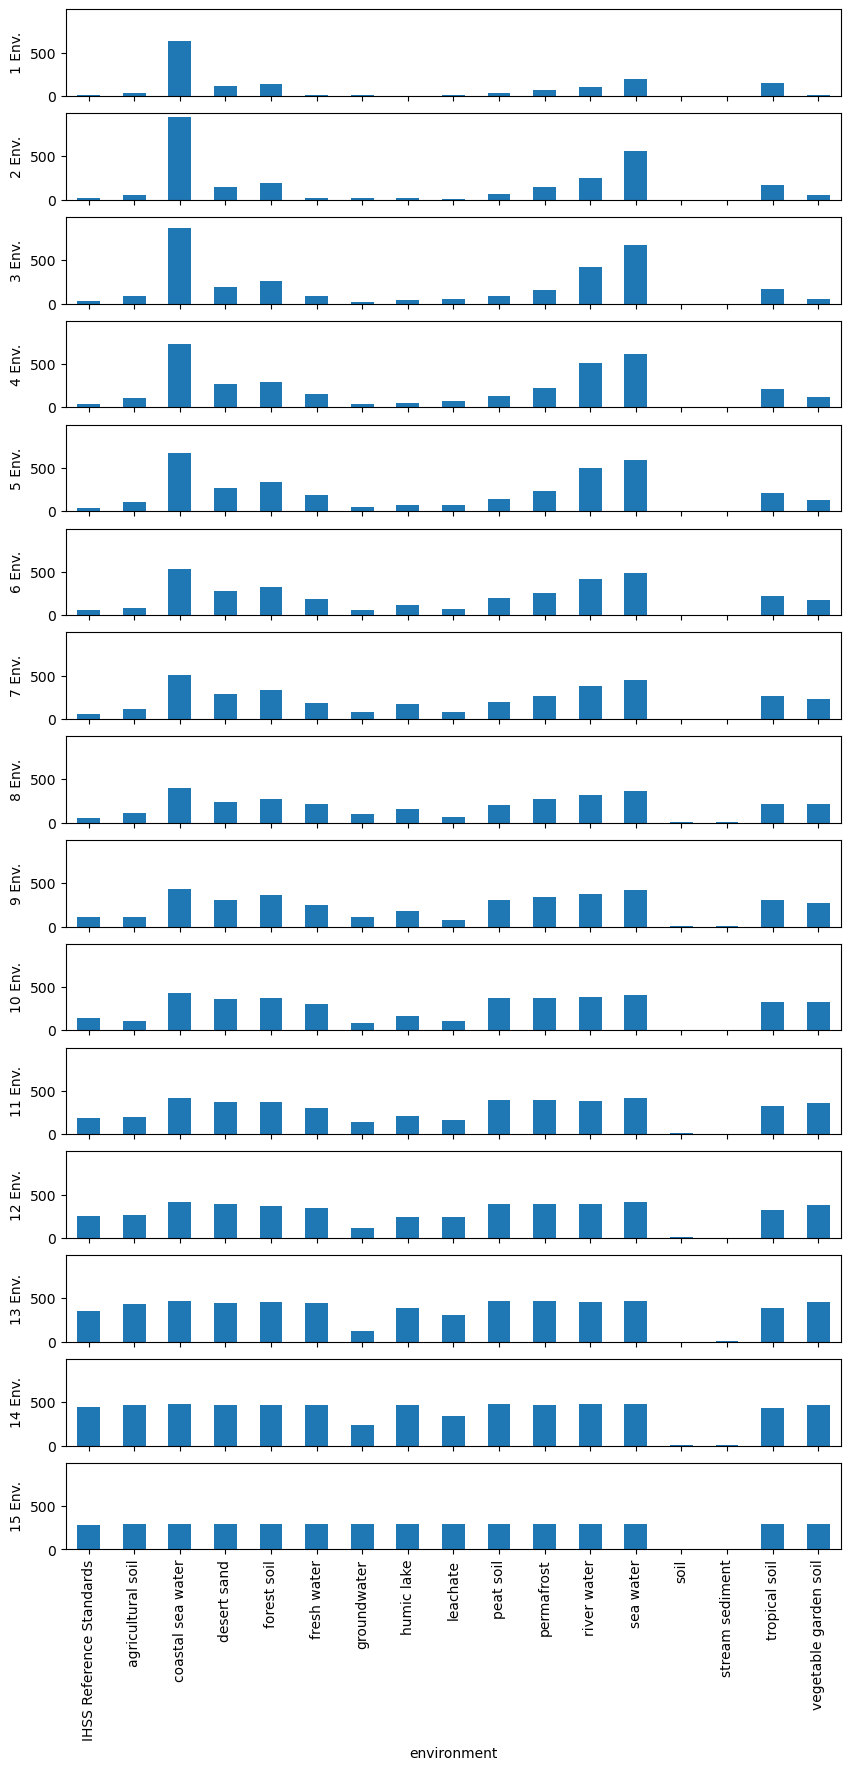

In [49]:
g = num_envs[num_envs['num_envs']>0].copy()
g = g.groupby('num_envs').size().reset_index().rename(columns={0:'count'})
# also list the count of nodes in each environment for each frequency
fig,ax = plt.subplots(ncols=1,nrows=15,figsize=(10,20),sharex=True,sharey=True)
for i in range(15):
    m = num_envs[num_envs['num_envs']==i+1].copy()
    m = m.sum()
    m = m.drop('num_envs')
    # m = m.sort_values(ascending=False)
    m.sort_index(inplace=True)
    m.plot.bar(ax=ax[i])
    ax[i].set_ylabel('%d Env.'%(i+1))


In [20]:
num_envs

,,environment,IHSS Reference Standards,agricultural soil,coastal sea water,desert sand,forest soil,fresh water,groundwater,humic lake,leachate,peat soil,permafrost,river water,sea water,soil,stream sediment,tropical soil,vegetable garden soil,num_envs
node_id,class_results,class_results_propagated,,,,,,,,,,,,,,,,,,
0.0,Unclassified,Unclassified,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
10.0,Unclassified,Unclassified,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,3
100.0,Dicarboxylic acids,Dicarboxylic acids,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2
10000.0,Unclassified,Unclassified,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,3
10004.0,Unclassified,Cinnamic acids and derivatives,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995.0,Unclassified,Unclassified,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
9996.0,Unclassified,Unclassified,0,0,1,1,1,0,0,0,0,0,1,1,1,0,0,1,0,7
9997.0,Unclassified,Unclassified,0,1,1,1,1,0,0,0,0,1,1,1,1,1,0,1,1,11


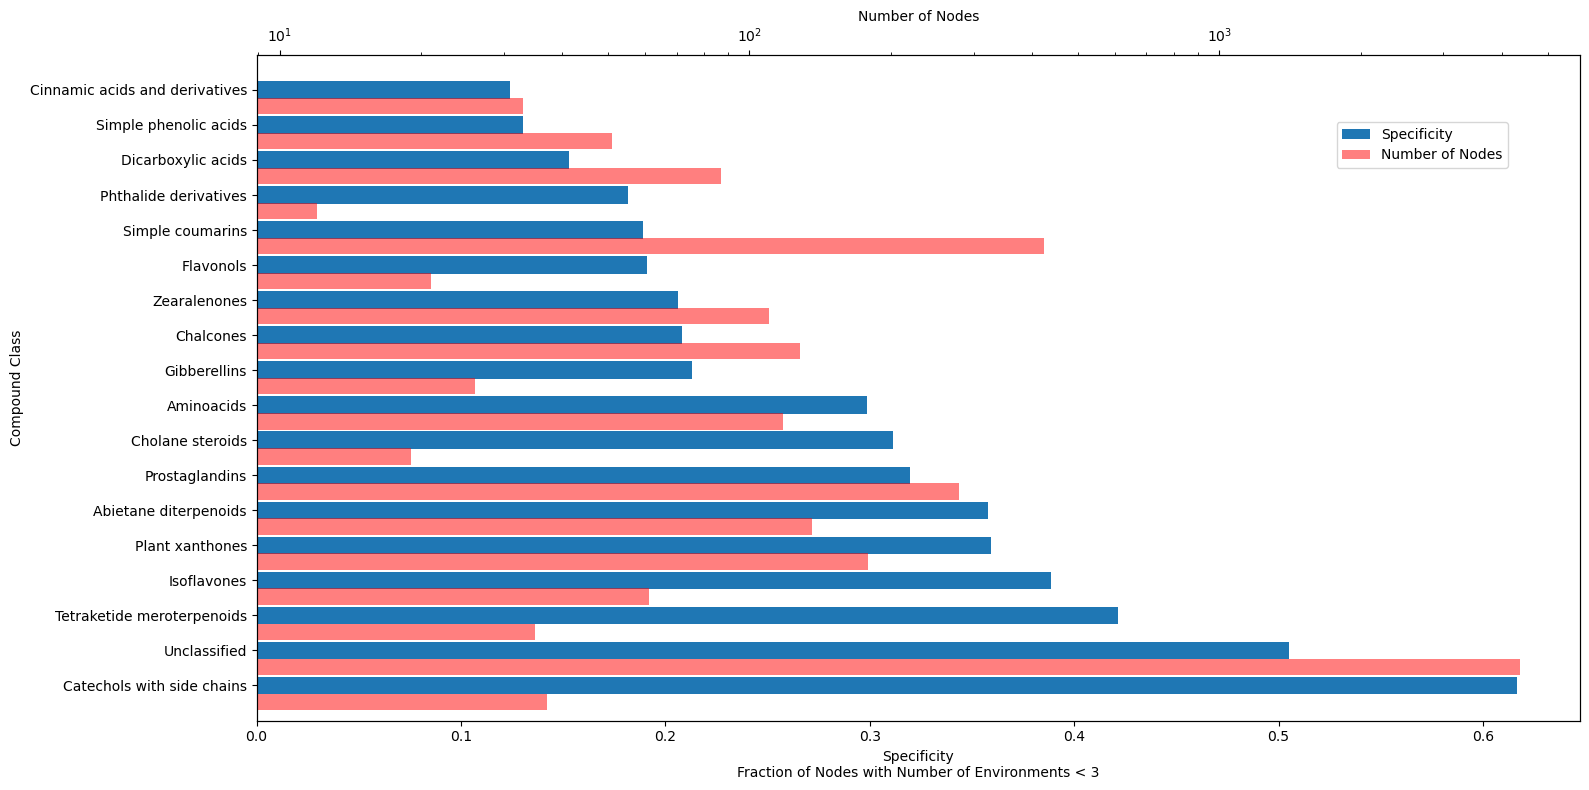

In [63]:
num_envs['specificity'] = num_envs['num_envs']<3
g = num_envs.reset_index().groupby('class_results_propagated')['specificity'].agg(['mean','sum'])
g = g[g['sum']>10]
g.sort_values('mean',ascending=False,inplace=True)
g.rename(columns={'mean':'specificity','sum':'number of nodes'},inplace=True)
g.to_csv('../../data/node_specificity_withcompoundclass.csv')

fig,ax = plt.subplots(figsize=(16,8))
g['specificity'].plot(kind='barh',ax=ax)
ax2 = ax.twiny()
# offset the second bar plot by bar width
ax2.spines['top'].set_position(('outward', 0))
# ax2.spines['top'].set_color('red')
# ax2.spines['top'].set_linewidth(2)
# ax2.set_xlim(ax.get_xlim())
ax2.set_xscale('log')

# Get the current bar positions and widths
positions = ax.get_yticks()
width = ax.patches[0].get_width()

ax2.set_ylabel('')
ax.set_xlabel('Specificity\nFraction of Nodes with Number of Environments < 3')
ax.set_ylabel('Compound Class')
ax.set_ylim(-1,len(g))

# Add the width to the positions for the second bar chart
ax2.barh(positions - width*0.75, g['number of nodes'], height=width*0.75, alpha=0.5, color='red')
ax2.set_xlabel('Number of Nodes')

# add a legend for both axes locate it in the upper right corner
fig.legend(['Specificity','Number of Nodes'],bbox_to_anchor=(0.95,0.85), loc="upper right")
plt.tight_layout()
plt.show()
fig.savefig('../../figures/node_specificity_withcompoundclass.pdf',bbox_inches='tight')


In [64]:
sum(num_envs['num_envs']<3),sum(num_envs['num_envs']>=3)

(6229, 10646)

Text(0, 0.5, 'Number of Nodes')

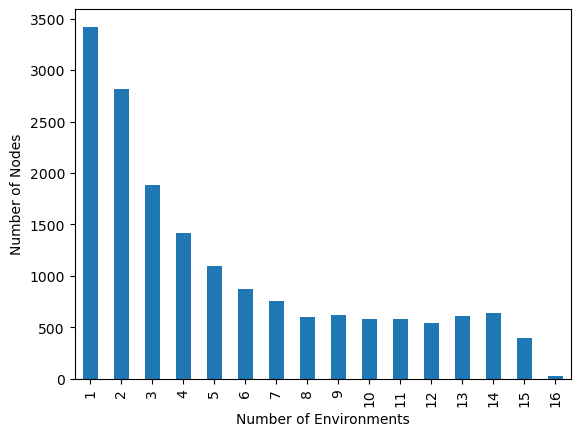

In [65]:
fig,ax = plt.subplots()
y = num_envs['num_envs'].value_counts()
y = y.sort_index()
y.plot(kind='bar',ax=ax)
ax.set_xlabel('Number of Environments')
ax.set_ylabel('Number of Nodes')

In [66]:
unique_nodes = ms2_data.groupby('environment')['node_id'].value_counts().reset_index(name='count')
unique_nodes = unique_nodes[unique_nodes['count']>0]
unique_nodes = unique_nodes.groupby('environment')['node_id'].unique()
unique_nodes = unique_nodes.to_dict()
# use the set cover algorithm to find the top species that cover the most nodes
# Create a dictionary where the keys are species and the values are sets of nodes that the species cover
species_nodes = {species: set(nodes) for species, nodes in unique_nodes.items()}



In [67]:
def set_cover(coverage_dict):
    coverage_dict = coverage_dict.copy()
    # Create a list of all unique nodes
    all_nodes = set()
    for nodes in coverage_dict.values():
        all_nodes.update(nodes)
    
    # Initialize an empty list to store selected species
    selected_species = []
    
    # While there are still uncovered nodes
    while all_nodes:
        # Find the species that covers the maximum number of uncovered nodes
        best_species = None
        best_covered = set()
        
        for species, nodes in coverage_dict.items():
            # Calculate the number of uncovered nodes covered by this species
            covered = nodes.intersection(all_nodes)
            
            # If this species covers more nodes than the current best, update
            if len(covered) > len(best_covered):
                best_species = species
                best_covered = covered
        
        # Add the best species to the selected species list
        selected_species.append(best_species)
        
        # Remove the covered nodes from the set of all nodes
        all_nodes.difference_update(best_covered)
        
        # Remove the best species from the dictionary to prevent it from being chosen again
        del coverage_dict[best_species]
    
    return selected_species

selected_species = set_cover(species_nodes)
print("Selected species:", selected_species[:5])


Selected species: ['coastal sea water', 'tropical soil', 'sea water', 'forest soil', 'desert sand']


In [68]:
node_data = at.graph_to_df()
num_nodes_total = node_data.shape[0]

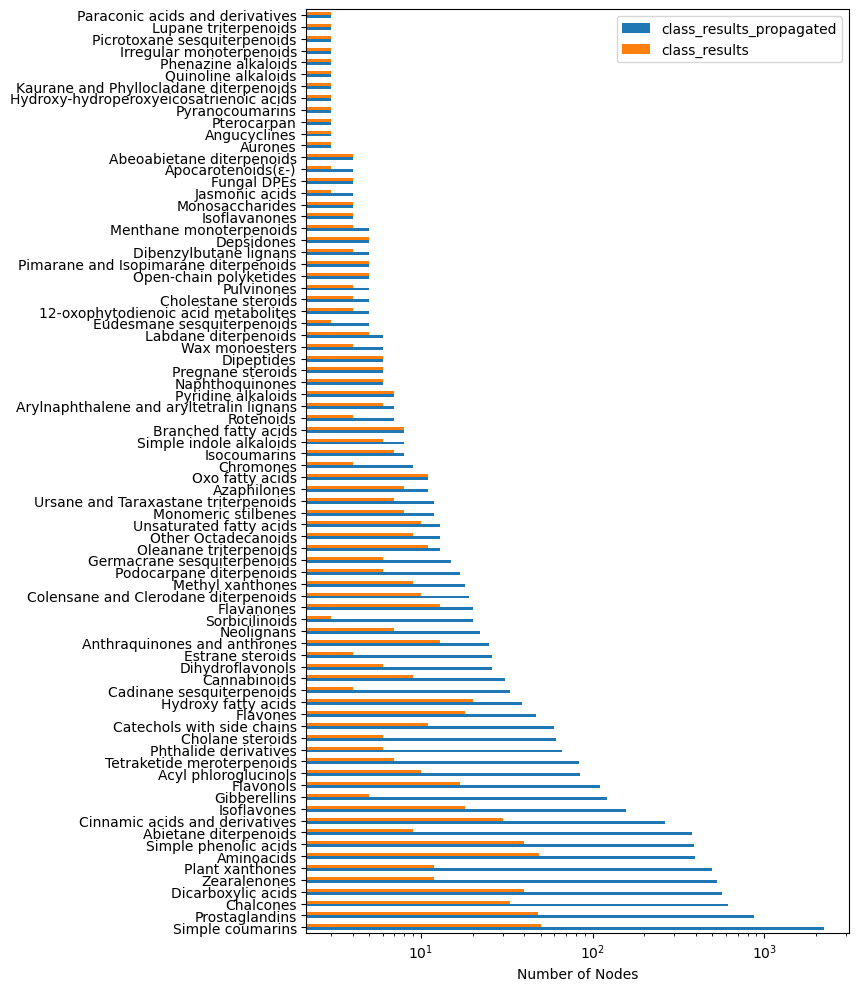

In [69]:
# bar chart the compound classes
y1 = node_data['class_results_propagated'].value_counts()#.apply(np.log10)
y2 = node_data['class_results'].value_counts()#.apply(np.log10)
y = pd.concat([y1,y2],axis=1)
y = y[y['class_results']>2]
fig,ax = plt.subplots(figsize=(7,12))
y.plot(kind='barh',ax=ax)
ax.set_xscale('log')
ax.set_xlabel('Number of Nodes')
plt.show()

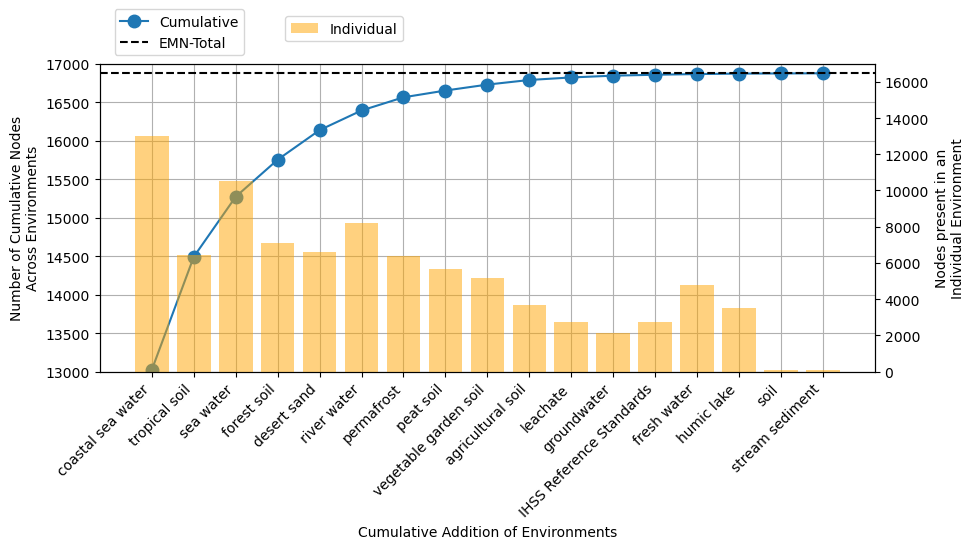

In [71]:
# for species in selected_species[:10]:
#     nodes = species_nodes[species]
#     print(f"Species {species} covers {len(nodes)} nodes")

n = len(selected_species)
# now show their combined coverage
combined_nodes = set()
combined_count = []
individual_count = []
for species in selected_species[:n]:
    combined_nodes.update(species_nodes[species])
    combined_count.append(len(combined_nodes))
    individual_count.append(len(species_nodes[species]))

fig,ax = plt.subplots(figsize=(10,4))
# make a second y-axis using twinx
ax2 = ax.twinx()
ax2.bar(range(n),individual_count,color='orange',alpha=0.5)
ax.plot(range(n),combined_count,'.-',markersize=18)
ax.set_xlabel('Cumulative Addition of Environments')
ax.set_ylabel('Number of Cumulative Nodes\nAcross Environments')
ax2.set_ylabel('Nodes present in an\nIndividual Environment')
# ax.set_title('Set Cover Algorithm for Selection')
ax.set_xticks(range(n))
ax.set_xticklabels(selected_species[:n],rotation=45,ha='right')
ax.grid(True)
ax.set_ylim(13000,17000)
ax.axhline(num_nodes_total,color='k',linestyle='--')
ax.legend(['Cumulative','EMN-Total'],loc='upper left',bbox_to_anchor=(0.01,1.20))
ax2.legend(['Individual'],loc='lower right',bbox_to_anchor=(0.4,1.05))
ax2.set_ylim(0,17000)
plt.show()

In [14]:
# make an upset plot
# from upsetplot import generate_counts
# from upsetplot import plot
# from upsetplot import from_memberships
from upsetplot import UpSet
# from upsetplot import plot_matrix

unique_nodes = ms2_data.groupby('environment')['node_id'].value_counts().reset_index(name='count')
unique_nodes = unique_nodes[unique_nodes['count']>0]
unique_nodes = unique_nodes.groupby('environment')['node_id'].unique()
unique_nodes = unique_nodes.to_dict()

import pandas as pd

# Convert the dictionary to a list of tuples
data = [(env, node) for env, nodes in unique_nodes.items() for node in nodes]

# Create a DataFrame from the list of tuples
# Create a DataFrame from the list of tuples
df = pd.DataFrame(data, columns=['Environment', 'Node'])

# Pivot the DataFrame to get the desired format
df = df.groupby('Node')['Environment'].apply(lambda x: pd.Series(1, x)).unstack().fillna(0)

# Convert the DataFrame to boolean
df = df.astype(bool)


{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

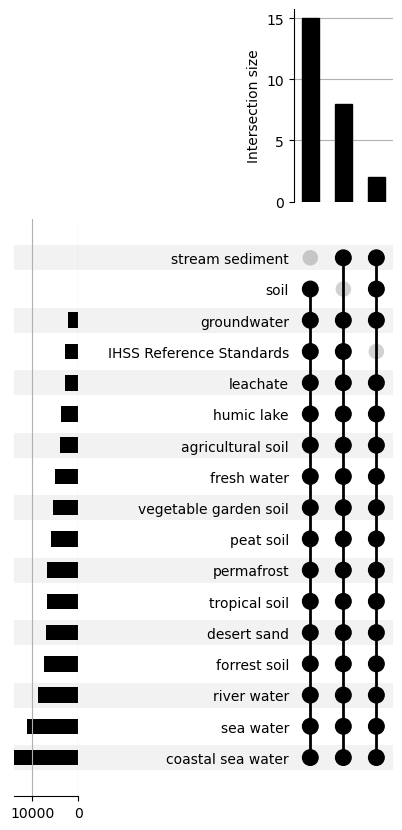

In [26]:
cols = df.columns.tolist()
# Group by the columns and count the number of True values
g = df.groupby(cols).size()

# Reset the index and rename the count column
# df = df.reset_index().rename(columns={0: 'count'})
upset = UpSet(g,min_degree=16,max_degree=17)
upset.plot()

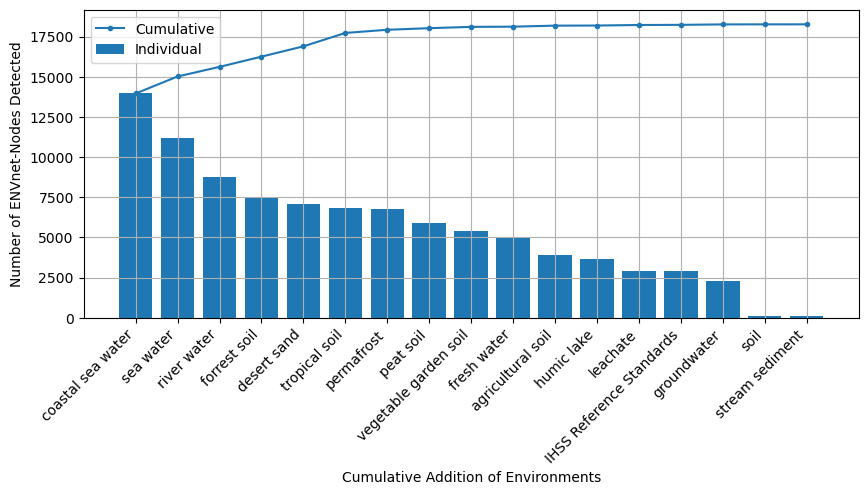

In [45]:
# how many nodes are covered by each environment
node_counts = ms2_data.groupby('environment')['node_id'].nunique()
node_counts = node_counts.sort_values(ascending=False)


n = len(node_counts)
# now show their combined coverage
combined_nodes = set()
combined_count = []
individual_count = []
for species in node_counts.index:
    combined_nodes.update(species_nodes[species])
    combined_count.append(len(combined_nodes))
    individual_count.append(len(species_nodes[species]))

fig,ax = plt.subplots(figsize=(10,4))
ax.plot(range(len(node_counts)),combined_count,'.-')
ax.bar(range(len(node_counts)),individual_count)
ax.set_xlabel('Cumulative Addition of Environments')
ax.set_ylabel('Number of ENVnet-Nodes Detected')
ax.set_xticks(range(len(node_counts)))
ax.set_xticklabels(node_counts.index,rotation=45,ha='right')
ax.legend(['Cumulative','Individual'])
ax.grid(True)
plt.show()


# # make a cumulative histogram of the node counts 
# ax.bar(range(len(node_counts)),node_counts)
# ax.set_xlabel('Environment')
# ax.set_ylabel('Number of ENVnet-Nodes Detected')
# ax.set_title('ENVnet-Nodes Detected in Different Environments')
# ax.set_xticks(range(len(node_counts)))
# ax.set_xticklabels(node_counts.index,rotation=45,ha='right')
# ax.grid(True)

In [ ]:

# Now you can create an UpSet plot
# upset = UpSet(df, subset_size='count')
# upset.plot(max_degree=1)


In [10]:
g = pd.merge(ms2_data,file_df,left_on='lcmsrun_observed',right_on='parquet',how='inner')
g.groupby('node_id').apply(lambda x: x['name'].unique()).value_counts()

[coastal sea water]                                                                                                                                             1400
[tropical soil]                                                                                                                                                  699
[sea water]                                                                                                                                                      420
[desert sand]                                                                                                                                                    330
[forrest soil]                                                                                                                                                   311
                                                                                                                                                                ... 
[vegetable

In [ ]:
# best_hits = best_hits[best_hits['peak_area']>1e4]
# best_hits[pd.notna(best_hits['ms2_score'])]

In [ ]:
def make_output_df(node_data,best_hits,filename='output.csv'):
    output = node_data.copy()
    output.set_index('node_id',inplace=True)
    output = output.join(best_hits.set_index('node_id'),rsuffix='_best_hit',how='left')
    output.to_csv(filename)
    return output
output_df = make_output_df(node_data,best_hits,filename='../../data/BestHits_PlantData.csv')
ms1_data.to_csv('../../data/Plants_ms1_data.csv')
ms2_data.to_csv('../../data/Plants_ms2_data.csv')

In [ ]:
sum(output_df['ms2_score']>0.75)

In [ ]:
ms2_data['plant'] = ms2_data['lcmsrun_observed'].apply(lambda x: os.path.basename(x).split('_')[12])

In [ ]:
d_sample = ms2_data.pivot_table(index='node_id',columns=['plant'],values='score',aggfunc='max',fill_value=0)
d_sample = d_sample>0.6
d_sample.sum().sort_values(ascending=False).head(20)

In [ ]:
files = ms1_data['lcmsrun_observed'].unique()
ms1_data['plant'] = ms1_data['lcmsrun_observed'].apply(lambda x: os.path.basename(x).split('_')[12])


In [ ]:
d_sample = ms1_data.pivot_table(index='node_id',columns=['plant'],values='peak_area',aggfunc='mean',fill_value=300)
d_sample.to_csv('PeakArea_ExudateData-groupedbyplant.csv') 
d_sample = d_sample>1e7


In [ ]:
d_sample.sum().sort_values(ascending=False).head(20)

In [ ]:
d_sample = ms1_data.pivot_table(index='node_id',columns=['lcmsrun_observed'],values='peak_area',aggfunc='mean',fill_value=300)
d_sample.to_csv('PeakArea_ExudateData.csv') 


In [ ]:
import pandas as pd
plant = pd.read_csv('PeakArea_PlantData.csv')